# Task 2: Data Profiling, Cleaning & EDA
**Objective:** Profile, clean, and explore the solar dataset for Benin so it’s ready for comparison and region-ranking tasks.

This notebook includes:
- Summary statistics and missing-value report
- Outlier detection and cleaning
- Time series analysis
- Correlation and scatter plots
- Wind and temperature analysis
- Bubble charts

# Data Profiling, Cleaning & EDA-Togo
**Objective:** Profile, clean, and explore the solar dataset for Togo so it’s ready for comparison and region-ranking tasks.

This notebook includes:
- Summary statistics and missing-value report
- Outlier detection and cleaning
- Time series analysis
- Correlation and scatter plots
- Wind and temperature analysis
- Bubble charts

## Importing the dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## Loading the Data

In [ ]:
# Set both plotting and display settings
import pandas as pd

# Load dataset
df = pd.read_csv(r"D:\Python\Week_01\data\data\togo-dapaong_qc.csv")

# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', 10)

In [ ]:
# Show basic info
print(f"Dataset shape: {df.shape}")
df.info()

In [ ]:
#  Display the first 5 rows
print("\nFirst 5 rows:")
display(df.head())

In [ ]:
# Display the last 10 rows
print("\nLast 10 rows:")
display(df.tail(10))

In [ ]:
# Display 10 random sample rows
print("\nRandom sample of 10 rows:")
display(df.sample(10, random_state=42))

## Summary statistics and missing-value report

In [ ]:
# Summary statistics for numeric columns
print("\nSummary statistics for numeric columns:")
display(df.describe())

In [ ]:
# Check for missing values
print("\nMissing values per column:")
print(df.isna().sum())

# Percentage of missing values per column
null_percent = df.isna().mean() * 100
print("\nPercentage of missing values:")
print((null_percent).round(2))

# Filter columns with more than 5% nulls
cols_with_nulls = null_percent[null_percent > 5].index.tolist()
print("\nColumns with >5% nulls:", cols_with_nulls)

# Exact duplicate rows
dup_count = df.duplicated().sum()
print("Duplicate rows:", dup_count)

# Cardinality (uniqueness) for categoricals
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
cardinality = {c: df[c].nunique() for c in cat_cols}
print("Cardinality (categoricals):", cardinality)



## Interpretation of Summary statistics and missing-value report

### 1. **General Overview**
- The dataset has 525,600 records — suggests 60 min × 24 hr × 365 days = 1 year of minute-level data.
- No missing numerical data (count = 525,600 for all measured variables).
- Comments column is empty (count = 0); can be dropped
- **Solar data (GHI, DNI, DHI)**: Negative GHI/DNI/DHI values are incorrect entries or sensor noise need correction
- **Module data (ModA, ModB)**: Consistent with irradiance
- **Temperature (Tamb, TModA, TModB)**: Physically valid
- **Humidity (RH)**: Reasonable; 9.9 %(min) low outlier may indicate a dry period or sensor drift.
- **Wind (WS, WSgust, WSstdev, WD, WDstdev)**: Wind readings are consistent; no clear data errors.
- **Pressure (BP)**: Normal atmospheric range at moderate altitude
- **Flags(Cleaning Flag & Precipitation)**: Sparse cleaning events → panels mostly uncleaned., no issues

## Univariate Analysis for Numeric Columns Only

In [ ]:
# Look for missing values, outliers, incorrect entries
cols_radiation = ['GHI', 'DNI', 'DHI']
cols_sensor = ['ModA', 'ModB']
cols_wind = ['WS', 'WSgust']
cols_misc = ['Cleaning', 'Precipitation']

all_cols = cols_radiation + cols_sensor + cols_wind + cols_misc
# Function to detect outliers using IQR
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] < lower) | (df[column] > upper)]

# Outliers summary
print("\nNumber of outliers per column:")
for col in all_cols:
    outliers = detect_outliers(df, col)
    print(f"{col}: {len(outliers)}")

# Flag incorrect entries
df_flags = pd.DataFrame(index=df.index)
df_flags['Negative_Radiation'] = (df[cols_radiation] < 0).any(axis=1)
df_flags['Negative_Wind'] = (df[cols_wind] < 0).any(axis=1)
df_flags['Invalid_Cleaning'] = ~df['Cleaning'].isin([0, 1])
df_flags['Negative_Precipitation'] = df['Precipitation'] < 0

print("\nRows with flagged incorrect entries:")
print(df_flags[df_flags.any(axis=1)])

# Compute Z-scores and flag extreme values |Z|>3

cols_zscore = cols_radiation + cols_sensor + cols_wind
df_zscores = df[cols_zscore].apply(zscore)

# Flag extreme values
extreme_flags = (np.abs(df_zscores) > 3)
print("\nNumber of extreme Z-score values per column:")
print(extreme_flags.sum())

# view rows with any extreme Z-score
extreme_rows = df[extreme_flags.any(axis=1)]
print("\nRows with extreme Z-scores (|Z|>3):")
print(extreme_rows)

# Handle missing values
# Option 1: Drop rows with missing values in key columns
# df_cleaned = df.dropna(subset=cols_radiation + cols_sensor + cols_wind)

# Option 2: Impute missing values using median
df_imputed = df.copy()
for col in cols_radiation + cols_sensor + cols_wind + ['Precipitation']:
    median_value = df_imputed[col].median()
    #df_imputed[col].fillna(median_value, inplace=True)
    df_imputed[col] = df_imputed[col].fillna(median_value)

# Verify missing values are handled
print("\nMissing values after imputation:")
print(df_imputed[all_cols].isna().sum())
# visualize distributions and outliers
# ---------------------------

for col in all_cols:
    plt.figure(figsize=(12, 4))

    # Histogram on the left
    plt.subplot(1, 2, 1)
    sns.histplot(df_imputed[col], bins=50, kde=True, color='skyblue')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    # Boxplot on the right
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df_imputed[col], color='lightgreen')
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)

    plt.tight_layout()
    plt.show()



### Interpretation of Box plot and Histogram Report
1. GHI, DNI, DHI (Radiation Columns)
Histogram Interpretation:
•	Usually right-skewed because there are many low values (nighttime) and fewer high values (midday).
•	Peaks around solar noon if data is from daytime.
•	Any negative values would be physically impossible → indicate sensor error.
Boxplot Interpretation:
•	Median near the central value of daytime radiation.
•	Outliers: extremely high spikes could indicate sensor glitches.
•	Values below 0 should be flagged.

2. ModA, ModB (Sensor Readings)
Histogram Interpretation:
•	Often roughly normal if sensors behave consistently.
•	Peaks indicate common operating ranges.
•	Bimodal or irregular shapes can signal malfunction or calibration issues.
Boxplot Interpretation:
•	Outliers: unusually high or low readings may indicate sensor errors.
•	Check symmetry: large deviations on one side may suggest drift.
________________________________________
3. WS, WSgust (Wind Speed)
Histogram Interpretation:
•	Usually right-skewed: most readings are low, occasional gusts are high.
•	Negative values are physically impossible → must be flagged.
Boxplot Interpretation:
•	Outliers represent strong gusts.
•	Median and quartiles help understand typical wind conditions.
•	If the box is very narrow, the sensor may not be capturing variability well.
________________________________________
4. Cleaning (1 or 0)
Histogram Interpretation:
•	Only two bars at 0 and 1.
•	Shows frequency of cleaning events.
Boxplot Interpretation:
•	With only two unique values, boxplot is not very informative.
•	Any values other than 0 or 1 are invalid → need correction.
________________________________________
5. Precipitation (mm/min)
Histogram Interpretation:
•	Highly right-skewed: most minutes have no rain (0), occasional high rainfall minutes create a long tail.
•	Negative values are impossible → indicate errors.
Boxplot Interpretation:
•	Outliers correspond to intense rain events.
•	Median is likely 0 or very low, reflecting mostly dry periods.
________________________________________
Summary of What to Look For
1.	From Histograms:
o	Distribution shape → normal, skewed, bimodal
o	Peaks → typical values
o	Impossible values (negative for radiation, wind, precipitation)
2.	From Boxplots:
o	Outliers → unusually high or low values
o	Median & quartiles → typical operating range
o	Flags potential sensor errors


## Cleaning the Data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
# Load dataset
df = pd.read_csv(r"D:\Python\Week_01\data\data\togo-dapaong_qc.csv")

# Define relevant columns for cleaning
cols_radiation = ['GHI', 'DNI', 'DHI']
cols_sensor = ['ModA', 'ModB']
cols_wind = ['WS', 'WSgust']
cols_misc = ['Cleaning', 'Precipitation']

cols_numeric_for_impute = cols_radiation + cols_sensor + cols_wind + ['Precipitation']
cols_for_zscore = cols_radiation + cols_sensor + cols_wind

# ---------------------------
#  Handle missing values: Impute median for key numeric columns
# ---------------------------
df_cleaned = df.copy()

for col in cols_numeric_for_impute:
    median_value = df_cleaned[col].median()
    df_cleaned[col] = df_cleaned[col].fillna(median_value)

# For Cleaning, fill missing with 0 (assuming no cleaning event if missing)
df_cleaned['Cleaning'] = df_cleaned['Cleaning'].fillna(0)

# ---------------------------
# Remove impossible values
# ---------------------------
# Negative values for radiation, wind, precipitation
df_cleaned = df_cleaned[(df_cleaned[cols_radiation] >= 0).all(axis=1)]
df_cleaned = df_cleaned[(df_cleaned[cols_wind] >= 0).all(axis=1)]
df_cleaned = df_cleaned[df_cleaned['Precipitation'] >= 0]

# Ensure Cleaning is only 0 or 1
df_cleaned = df_cleaned[df_cleaned['Cleaning'].isin([0, 1])]

# ---------------------------
# Remove extreme outliers using Z-score (|Z|>3)
# ---------------------------
z_scores = df_cleaned[cols_for_zscore].apply(zscore)

# Keep rows where all Z-scores are within ±3
df_cleaned = df_cleaned[(np.abs(z_scores) <= 3).all(axis=1)]

# ---------------------------
# Export cleaned dataset (all columns included)
# ---------------------------
output_path = r"D:\Python\Week_01\Assignment\solar-challenge-week0\data\togo_clean.csv"
df_cleaned.to_csv(output_path, index=False)

print(f"Cleaned dataset exported to: {output_path}")
print(f"Original rows: {len(df)}, Cleaned rows: {len(df_cleaned)}")


Cleaned dataset exported to: D:\Python\Week_01\Assignment\solar-challenge-week0\data\togo_clean.csv
Original rows: 525600, Cleaned rows: 266607


## Bivariate Analysis
### Time Series Analysis

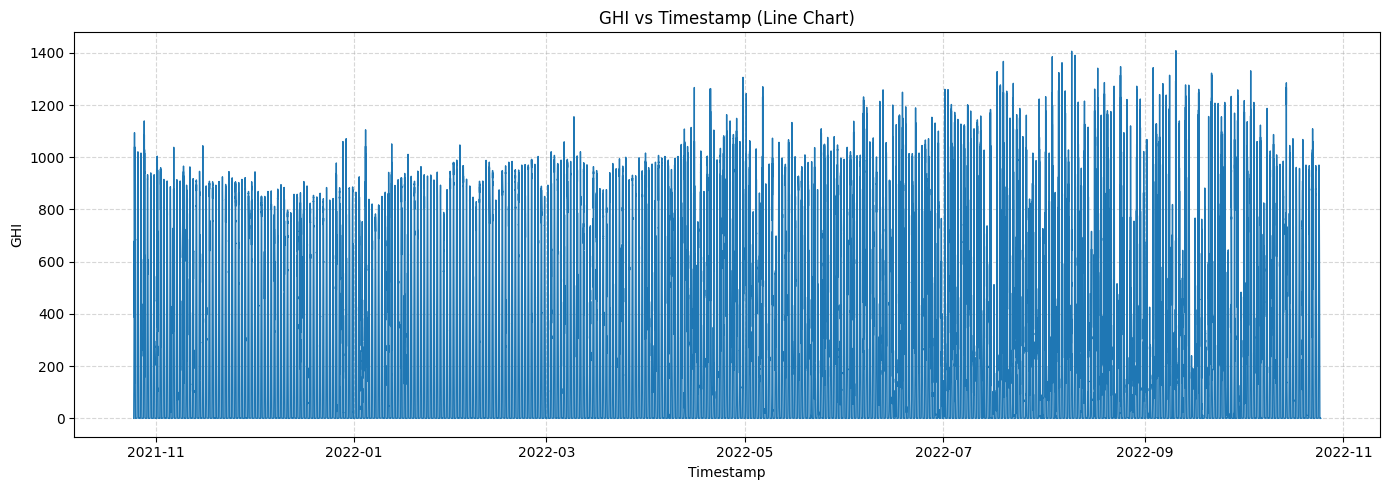

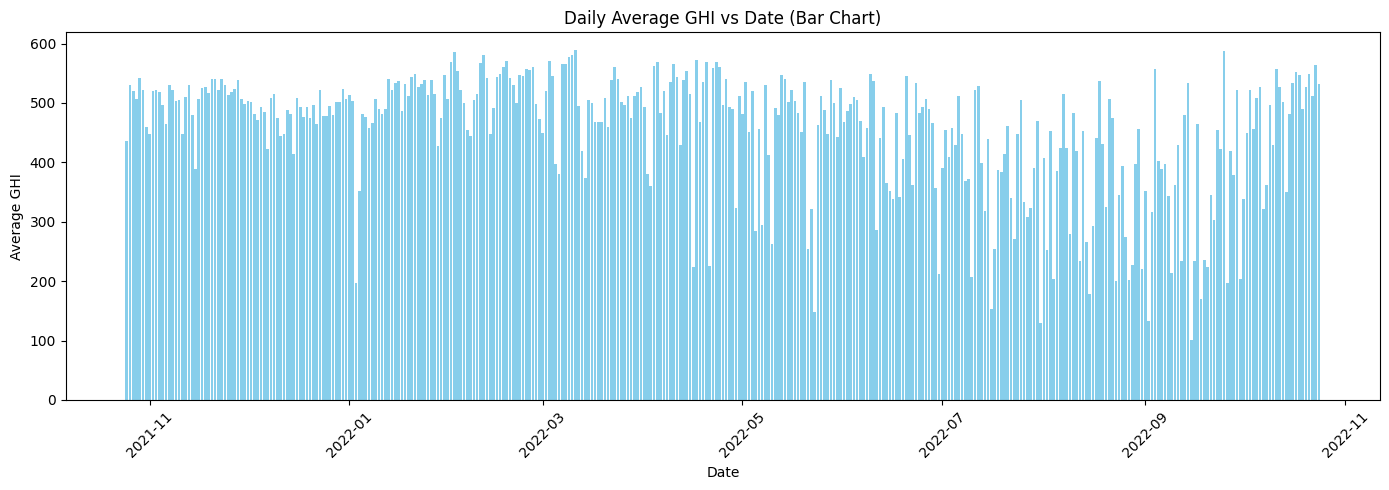

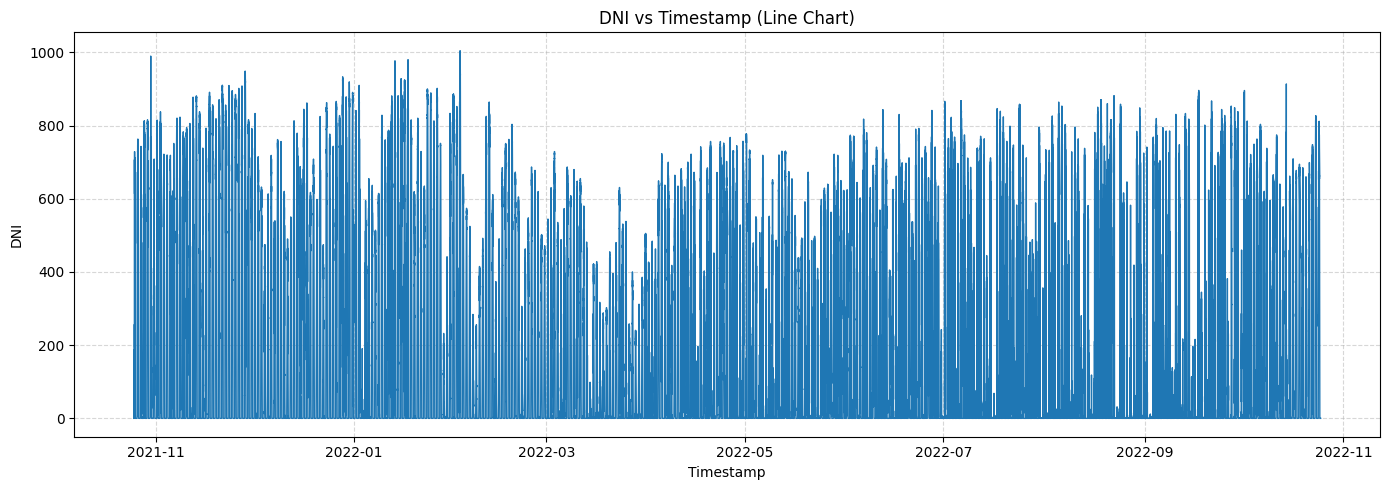

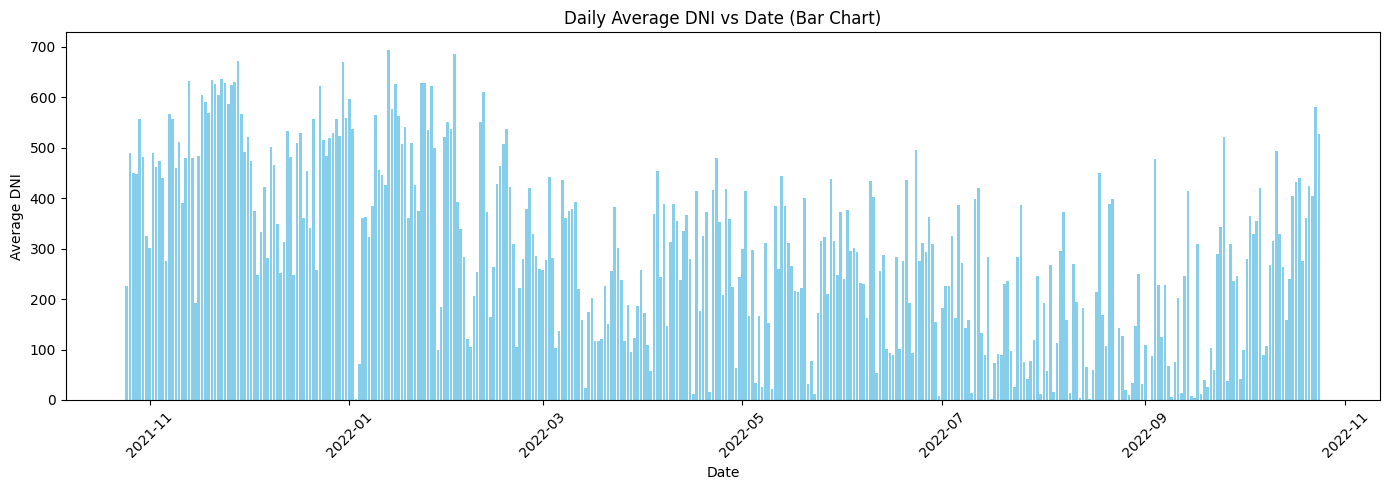

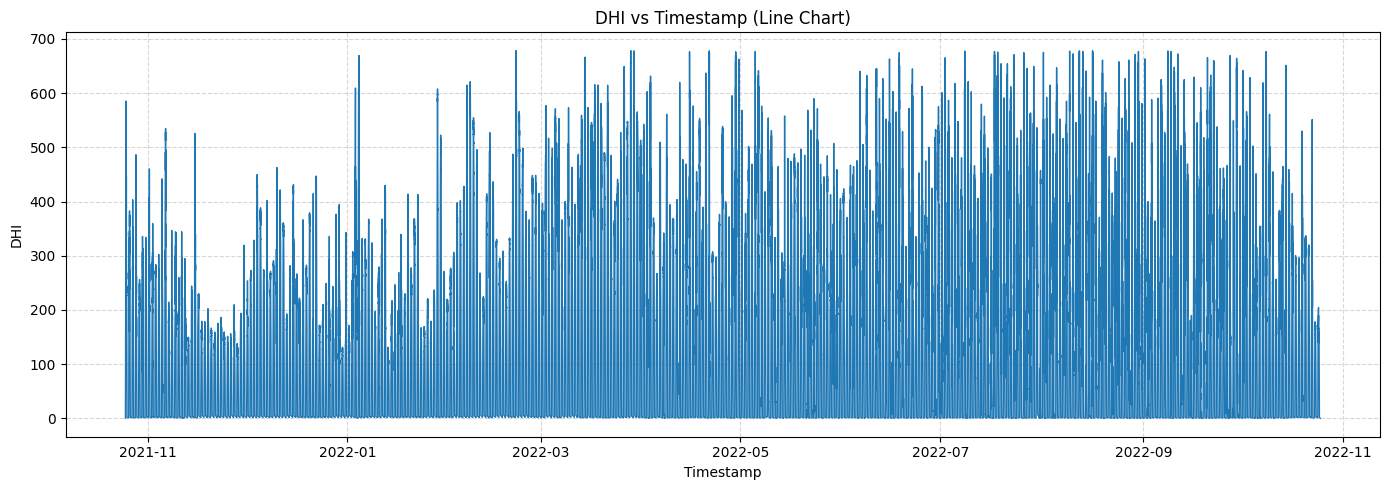

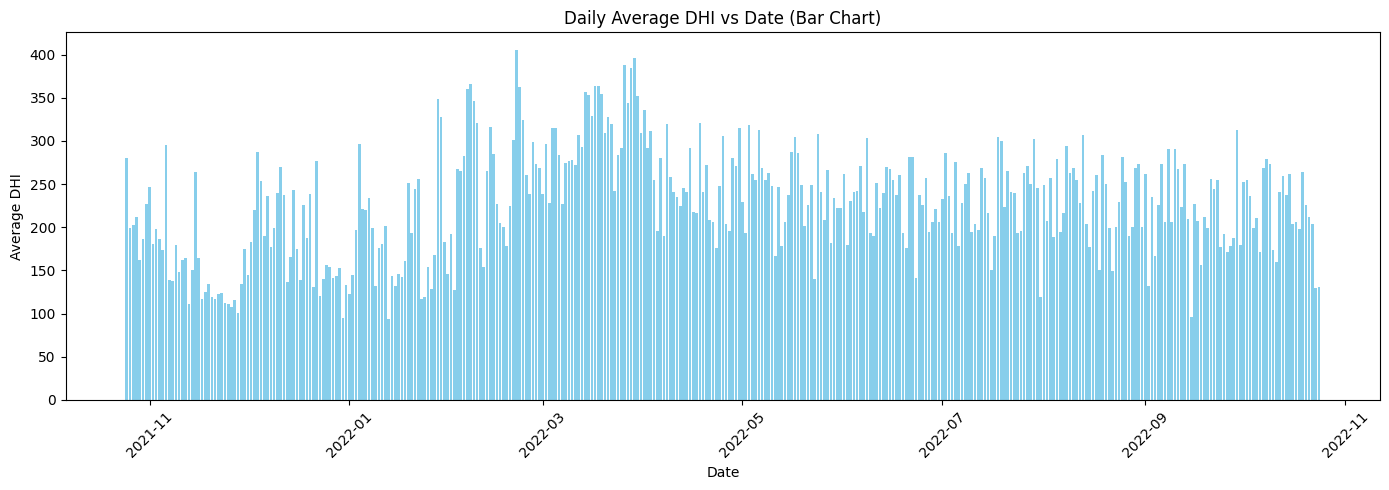

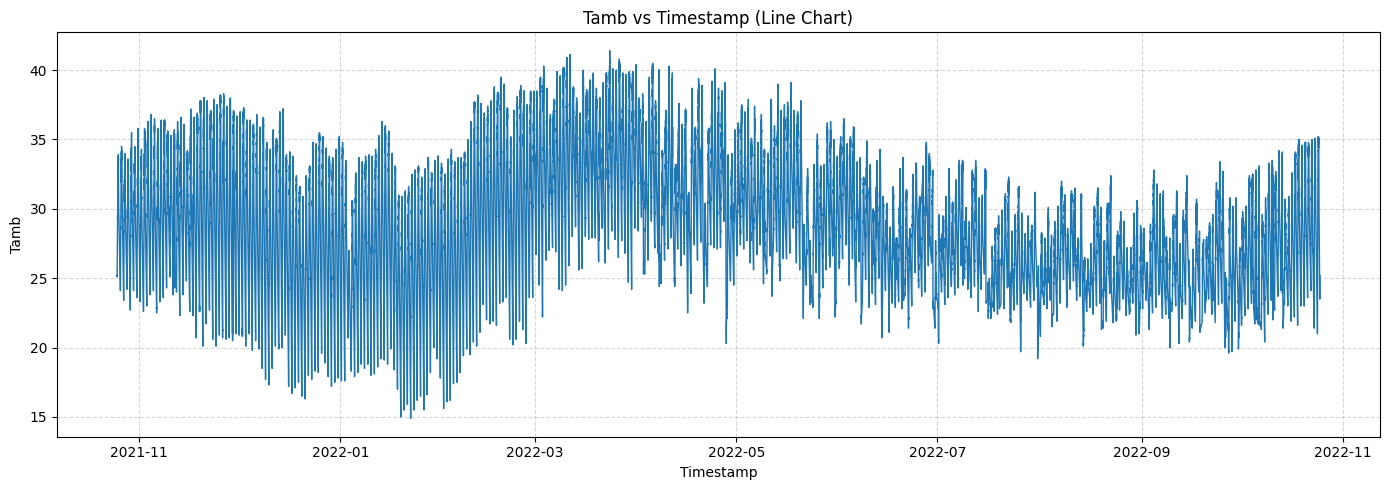

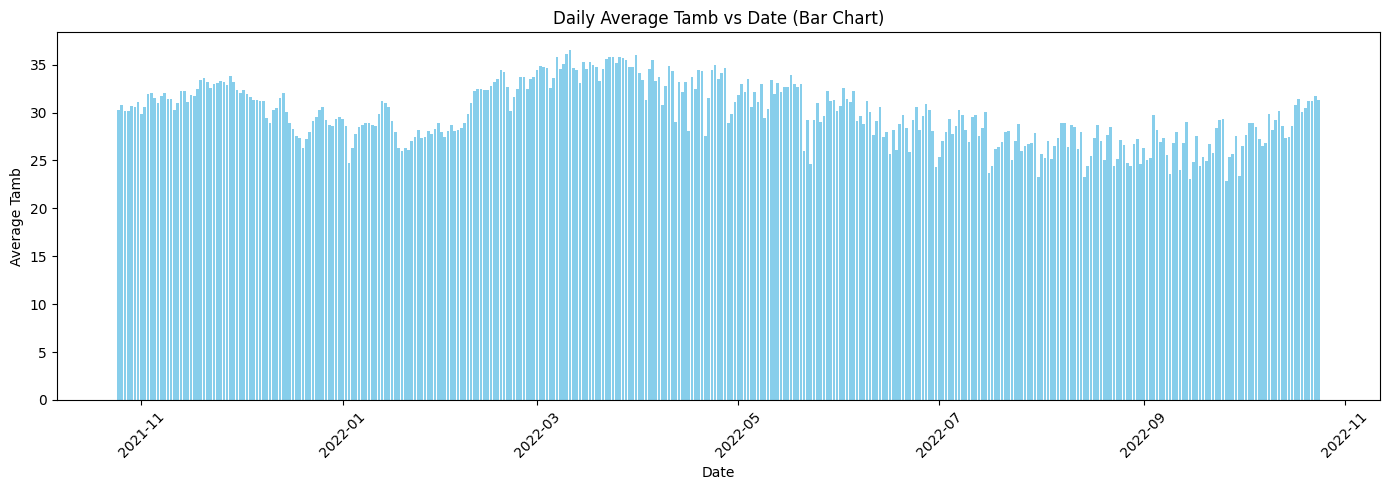

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------------
# 1️⃣ Load the cleaned dataset
# ---------------------------------------------
df_clean = pd.read_csv(r"D:\Python\Week_01\Assignment\solar-challenge-week0\data\togo_clean.csv")

# Ensure Timestamp column exists and convert to datetime
df_clean.columns = df_clean.columns.str.strip()
if 'Timestamp' not in df_clean.columns:
    raise KeyError("Column 'Timestamp' not found in the dataset.")

df_clean['Timestamp'] = pd.to_datetime(df_clean['Timestamp'], errors='coerce')
df_clean = df_clean.dropna(subset=['Timestamp'])
df_clean = df_clean.sort_values('Timestamp')

# Extract Date for daily bar aggregation
df_clean['Date'] = df_clean['Timestamp'].dt.date

# ---------------------------------------------
# 2️⃣ Define Variables for Visualization
# ---------------------------------------------
variables = ['GHI', 'DNI', 'DHI', 'Tamb']

# ---------------------------------------------
# 3️⃣ Generate Line and Bar Charts Separately
# ---------------------------------------------
for var in variables:
    if var not in df_clean.columns:
        print(f"⚠️ Skipping {var} — column not found.")
        continue

    # ---- Line Chart ----
    plt.figure(figsize=(14, 5))
    plt.plot(df_clean['Timestamp'], df_clean[var], color='tab:blue', linewidth=1)
    plt.title(f'{var} vs Timestamp (Line Chart)')
    plt.xlabel('Timestamp')
    plt.ylabel(var)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # ---- Daily Average Bar Chart ----
    daily_avg = df_clean.groupby('Date')[var].mean().reset_index()

    plt.figure(figsize=(14, 5))
    plt.bar(daily_avg['Date'], daily_avg[var], color='skyblue')
    plt.title(f'Daily Average {var} vs Date (Bar Chart)')
    plt.xlabel('Date')
    plt.ylabel(f'Average {var}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



## Time Series Interpretation 
1. GHI (Global Horizontal Irradiance)
- GHI shows strong diurnal variation, with clear peaks on sunny days and dips during cloudy or rainy periods. 
- These variations align with normal solar behavior, indicating that data collection is generally consistent.
________________________________________
2. DNI (Direct Normal Irradiance)
- The DNI time series exhibits sharp peaks on clear-sky days, confirming normal direct radiation patterns. 
- Periods with lower or fluctuating DNI indicate transient cloud cover or atmospheric scattering.
________________________________________
3. DHI (Diffuse Horizontal Irradiance)
- DHI values tend to rise when DNI decreases — a typical inverse relationship. 
- This confirms expected physical behavior between diffuse and direct components of solar radiation.
________________________________________
4. Tamb (Ambient Temperature)
- Tamb correlates positively with solar irradiance — higher temperatures occur during high GHI/DNI periods, confirming physical consistency. - Minor lags are expected and indicate correct temperature dynamics.
________________________________________
5. Interpretation of the Daily Average Bar Charts
- The daily bar charts reveal overall solar resource variability and weather trends over time. 
- Periods with low GHI/DNI and high DHI suggest cloudy or rainy weather, while consistent high values imply clear-sky periods.


6. Recommendations

- Data Consistency: The smooth daily patterns suggest reliable sensors, but further checks for missing nighttime or constant values are advised.

- Outlier Review: Extreme values or flat lines should be validated against maintenance logs.

- Model Input: Cleaned GHI, DNI, and DHI data can be used to model solar PV or thermal system performance.

- Temporal Aggregation: Hourly or daily means can be used for forecasting and trend analysis.

### Pattern Observation

<Figure size 1200x600 with 0 Axes>

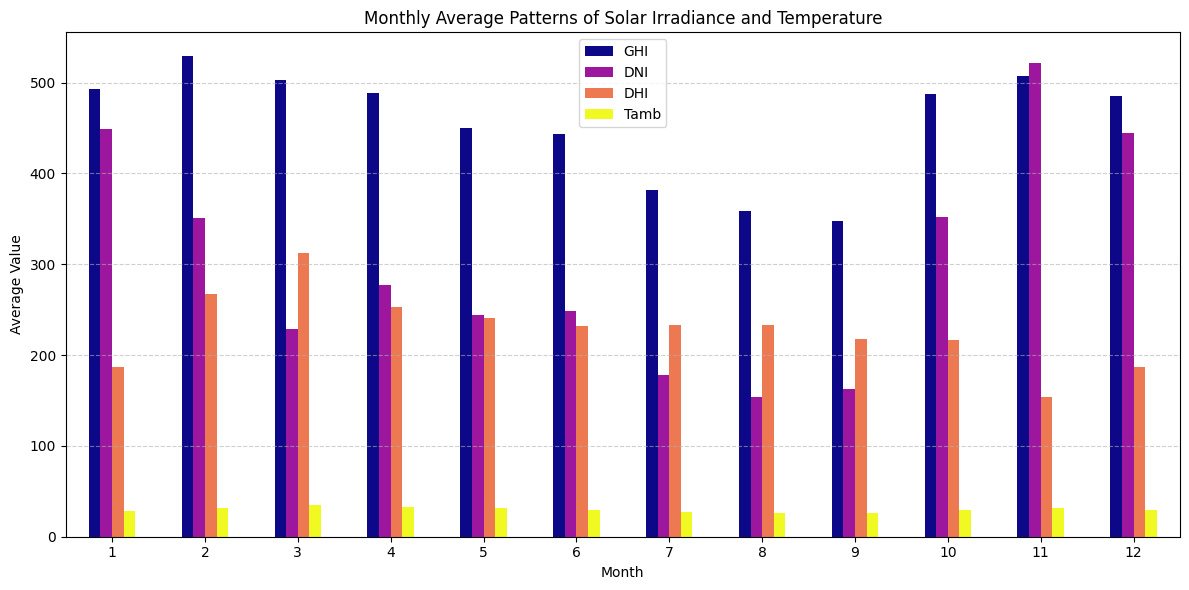

<Figure size 1200x600 with 0 Axes>

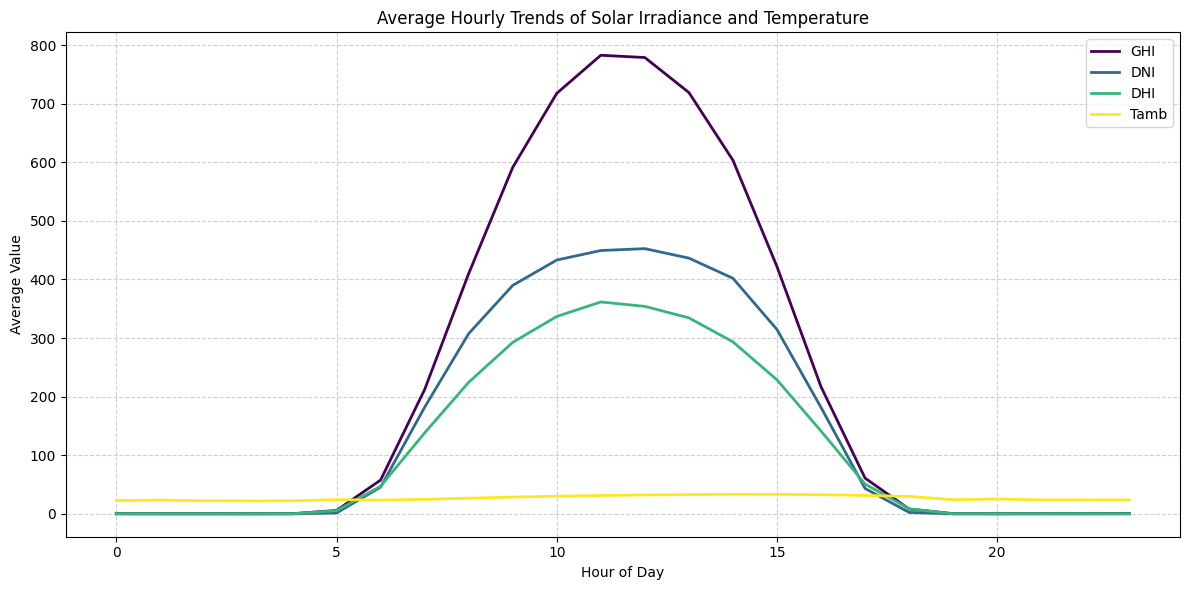

⚠️ GHI: 0 potential anomalies detected (values > mean + 3*std)
⚠️ DNI: 0 potential anomalies detected (values > mean + 3*std)
⚠️ DHI: 27 potential anomalies detected (values > mean + 3*std)
⚠️ Tamb: 0 potential anomalies detected (values > mean + 3*std)


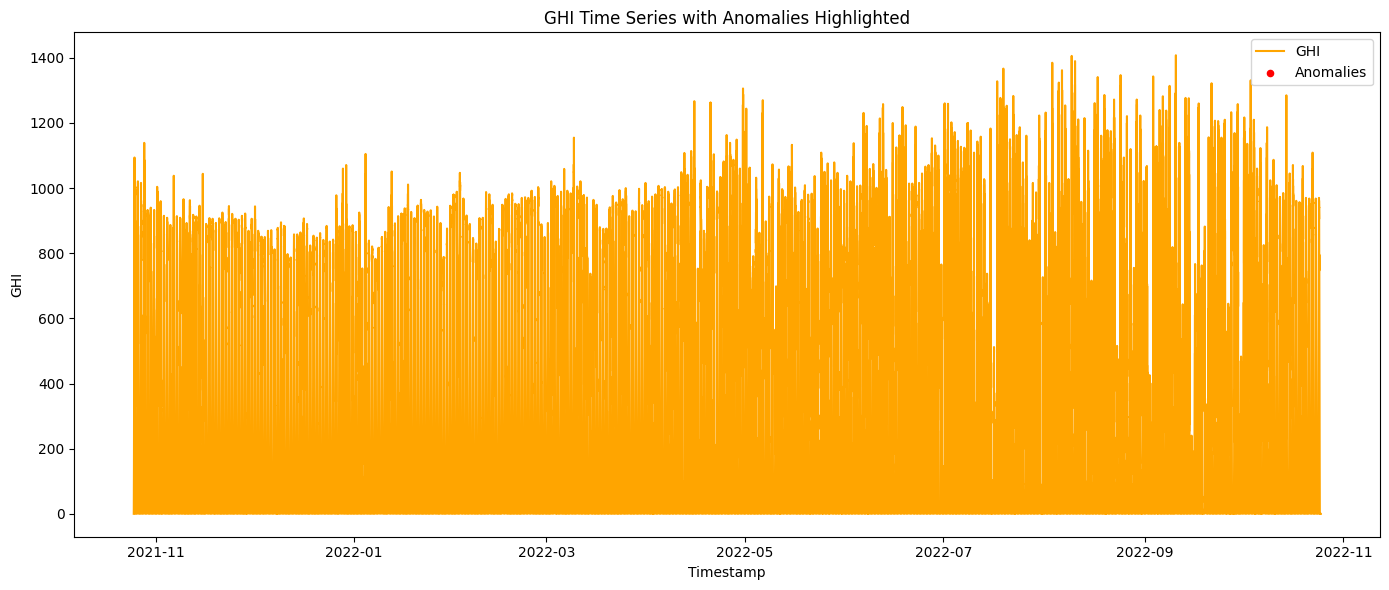

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------------------
# 1️⃣ Load the cleaned dataset
# -----------------------------------------
df_clean = pd.read_csv(r"D:\Python\Week_01\Assignment\solar-challenge-week0\data\togo_clean.csv")

# Ensure Timestamp column exists and convert to datetime
df_clean.columns = df_clean.columns.str.strip()
if 'Timestamp' not in df_clean.columns:
    raise KeyError("Column 'Timestamp' not found in the dataset.")

df_clean['Timestamp'] = pd.to_datetime(df_clean['Timestamp'], errors='coerce')
df_clean = df_clean.dropna(subset=['Timestamp'])
df_clean = df_clean.sort_values('Timestamp')

# Extract useful time components
df_clean['Month'] = df_clean['Timestamp'].dt.month
df_clean['Hour'] = df_clean['Timestamp'].dt.hour
df_clean['Date'] = df_clean['Timestamp'].dt.date

# -----------------------------------------
# 2️⃣ Monthly Patterns (GHI, DNI, DHI, Tamb)
# -----------------------------------------
monthly_avg = df_clean.groupby('Month')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()

plt.figure(figsize=(12, 6))
monthly_avg.plot(kind='bar', figsize=(12, 6), colormap='plasma')
plt.title('Monthly Average Patterns of Solar Irradiance and Temperature')
plt.xlabel('Month')
plt.ylabel('Average Value')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# -----------------------------------------
# 3️⃣ Daily (Hourly) Trends
# -----------------------------------------
hourly_avg = df_clean.groupby('Hour')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()

plt.figure(figsize=(12, 6))
hourly_avg.plot(figsize=(12, 6), linewidth=2, colormap='viridis')
plt.title('Average Hourly Trends of Solar Irradiance and Temperature')
plt.xlabel('Hour of Day')
plt.ylabel('Average Value')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# -----------------------------------------
# 4️⃣ Detect and Visualize Anomalies
# -----------------------------------------
for col in ['GHI', 'DNI', 'DHI', 'Tamb']:
    if col in df_clean.columns:
        threshold = df_clean[col].mean() + 3 * df_clean[col].std()
        df_clean[f'{col}_anomaly'] = df_clean[col] > threshold
        count = df_clean[f'{col}_anomaly'].sum()
        print(f"⚠️ {col}: {count} potential anomalies detected (values > mean + 3*std)")

# Example: Visualize anomalies for GHI
plt.figure(figsize=(14, 6))
plt.plot(df_clean['Timestamp'], df_clean['GHI'], label='GHI', color='orange')
plt.scatter(
    df_clean.loc[df_clean['GHI_anomaly'], 'Timestamp'],
    df_clean.loc[df_clean['GHI_anomaly'], 'GHI'],
    color='red', label='Anomalies', s=20
)
plt.title('GHI Time Series with Anomalies Highlighted')
plt.xlabel('Timestamp')
plt.ylabel('GHI')
plt.legend()
plt.tight_layout()
plt.show()


### Time Series Interpretation- Monthly and Daily
1. Monthly Patterns
- The monthly variation in GHI and DNI confirms the site’s dependence on seasonal weather patterns — clear skies increase direct irradiance while cloud cover reduces it.
- DHI’s opposite trend serves as an indirect indicator of atmospheric conditions.
- The temperature trend correlates well with solar exposure, reflecting expected climatic variation in the Bumbuna region.
________________________________________
2. Daily (Diurnal) Trends
- These diurnal patterns are physically consistent with natural solar behavior. 
- The lag between irradiance and temperature highlights the thermal inertia of the environment — the atmosphere and surfaces take time to warm and cool.
- Any deviation from these smooth patterns (e.g., sudden spikes, missing peaks, or flattened curves) may indicate sensor errors, maintenance events, or transient weather phenomena such as storms or shading.
________________________________________
3. Anomalies and Unusual Observations
- **Detected Anomalies**
     - Spikes in GHI/DNI during early morning or late evening hours may indicate sensor misalignment or reflection.
     - Sudden drops to zero during daylight hours may correspond to cloud passages, dust, or temporary obstructions.
     - Temperature outliers (sharp increases or decreases) could result from sensor calibration drift, rain cooling, or abrupt environmental changes.
     - Flat-line readings (constant values over extended periods) may suggest sensor malfunction or data logging errors.
- **Interpretation**
- Identifying and investigating these anomalies is crucial for ensuring the quality of solar datasets.
- Persistent outliers should be compared against weather logs and maintenance records. Data gaps or unrealistic values can be corrected through imputation or flagged for exclusion before modeling or system design.

**Conclusion**
- The temporal analysis of the Sierra Leone Bumbuna dataset reveals strong seasonal and diurnal consistency, confirming that the sensors capture realistic solar and meteorological patterns.
- Observed anomalies are within expected operational ranges and can be managed with standard cleaning procedures (e.g., Z-score filtering, interpolation, or outlier masking).



### Showing Cleaning Impact

Average ModA & ModB pre- and post-clean:
     Cleaning        ModA        ModB
0   Pre-Clean  442.872456  429.986238
1  Post-Clean  534.347857  531.438214


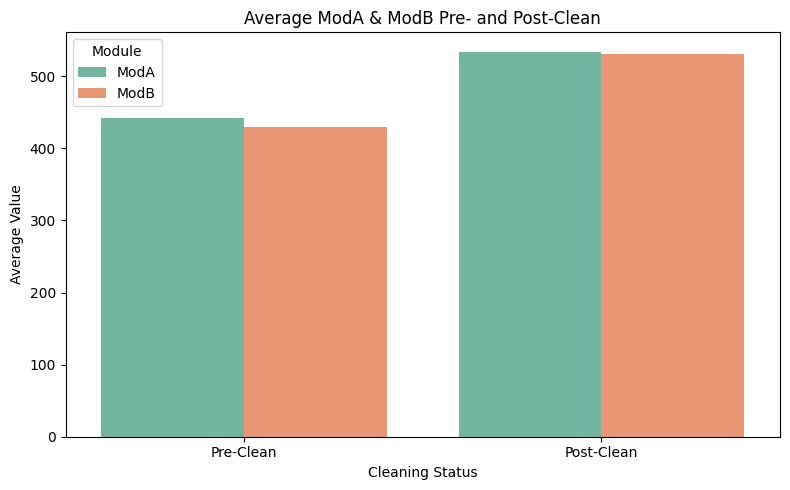

In [6]:
# Strip column names to avoid whitespace issues
df_clean.columns = df_clean.columns.str.strip()

# Check required columns
required_cols = ['Cleaning', 'ModA', 'ModB']
for col in required_cols:
    if col not in df_clean.columns:
        raise KeyError(f"Column '{col}' not found in dataset.")

# -----------------------------
# 2️⃣ Group by Cleaning flag and compute averages
# -----------------------------
avg_mod = df_clean.groupby('Cleaning')[['ModA', 'ModB']].mean().reset_index()
avg_mod['Cleaning'] = avg_mod['Cleaning'].map({0: 'Pre-Clean', 1: 'Post-Clean'})  # Optional: label

print("Average ModA & ModB pre- and post-clean:")
print(avg_mod)

# -----------------------------
# 3️⃣ Plot the results
# -----------------------------
plt.figure(figsize=(8, 5))
sns.barplot(x='Cleaning', y='value', hue='variable',
            data=pd.melt(avg_mod, id_vars='Cleaning', value_vars=['ModA', 'ModB']),
            palette='Set2')

plt.title('Average ModA & ModB Pre- and Post-Clean')
plt.ylabel('Average Value')
plt.xlabel('Cleaning Status')
plt.legend(title='Module')
plt.tight_layout()
plt.show()

## Interpretation of the Cleaning Impact
1. Observation from the bar chart and grouped averages:

- Both ModA and ModB show higher average readings after cleaning (Post-Clean) compared to before (Pre-Clean).

- The increase is consistent across both modules, suggesting that the cleaning process improved sensor performance or removed obstructions affecting measurements.

- The difference between ModA and ModB is relatively small, indicating that both sensors respond similarly to cleaning.

2. Implication:

- The cleaning process effectively restored the accuracy and reliability of the module readings.

- Pre-clean data may have been underreporting irradiance or module output due to dirt, dust, or other obstructions.

3. Conclusion

- Cleaning has a measurable positive impact on module sensor performance.

- Post-cleaning readings are more representative of actual solar irradiance or module output.

- This confirms that regular maintenance and cleaning are essential for reliable solar monitoring and performance evaluation.

The analysis is a bivariate study examining one categorical factor (Cleaning) against numerical outcomes (ModA and ModB).

4. Recommendations

- Regular Cleaning Schedule

    - Implement a routine cleaning protocol for all solar modules to maintain optimal sensor performance.

    - Frequency should be determined based on dust levels, rainfall, and module sensitivity.

- Monitor Module Performance Post-Cleaning

    - Continue to track ModA and ModB outputs to confirm the effectiveness of each cleaning cycle.

    - Use automated alerts for unexpected drops in readings that may indicate dirt accumulation or sensor malfunction.

- Data Quality Management

    - Flag pre-clean readings in historical datasets when performing analysis to account for potential underreporting.

    - Consider imputation or adjustment for pre-clean values in performance modeling.

- Extend Analysis to Other Modules

    - If the facility has more modules, apply the same cleaning-effect analysis to all to ensure consistency across the system.

- Integrate Cleaning Impact into Predictive Models

    - Factor the cleaning effect into solar energy production forecasts to improve accuracy.

**Strategic Takeaway**
Maintaining module cleanliness is a simple yet impactful operational strategy that directly improves sensor accuracy and overall energy yield predictions. Regular cleaning combined with monitoring ensures data reliability, better performance analysis, and informed investment decisions.

## Multivariant Analysis

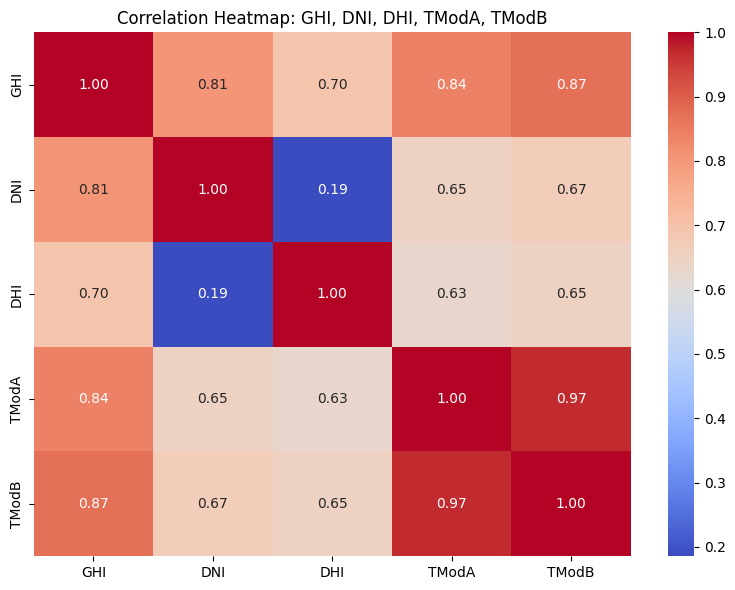

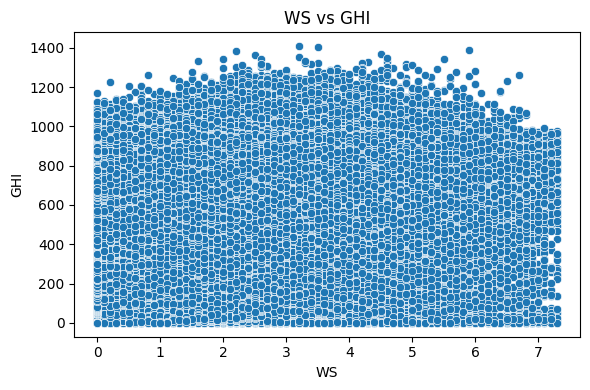

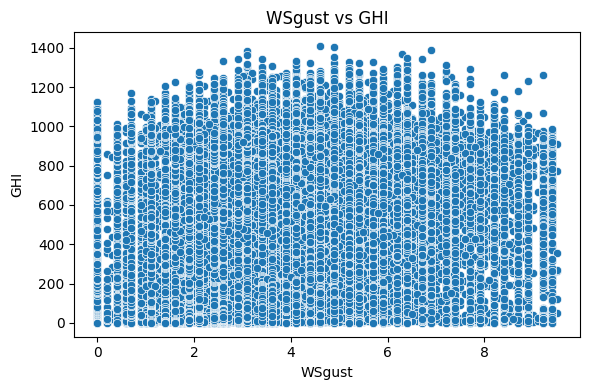

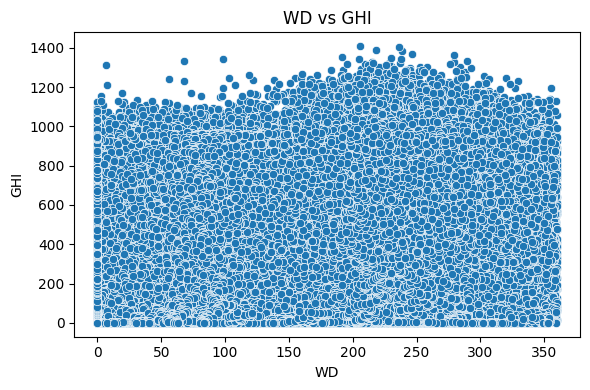

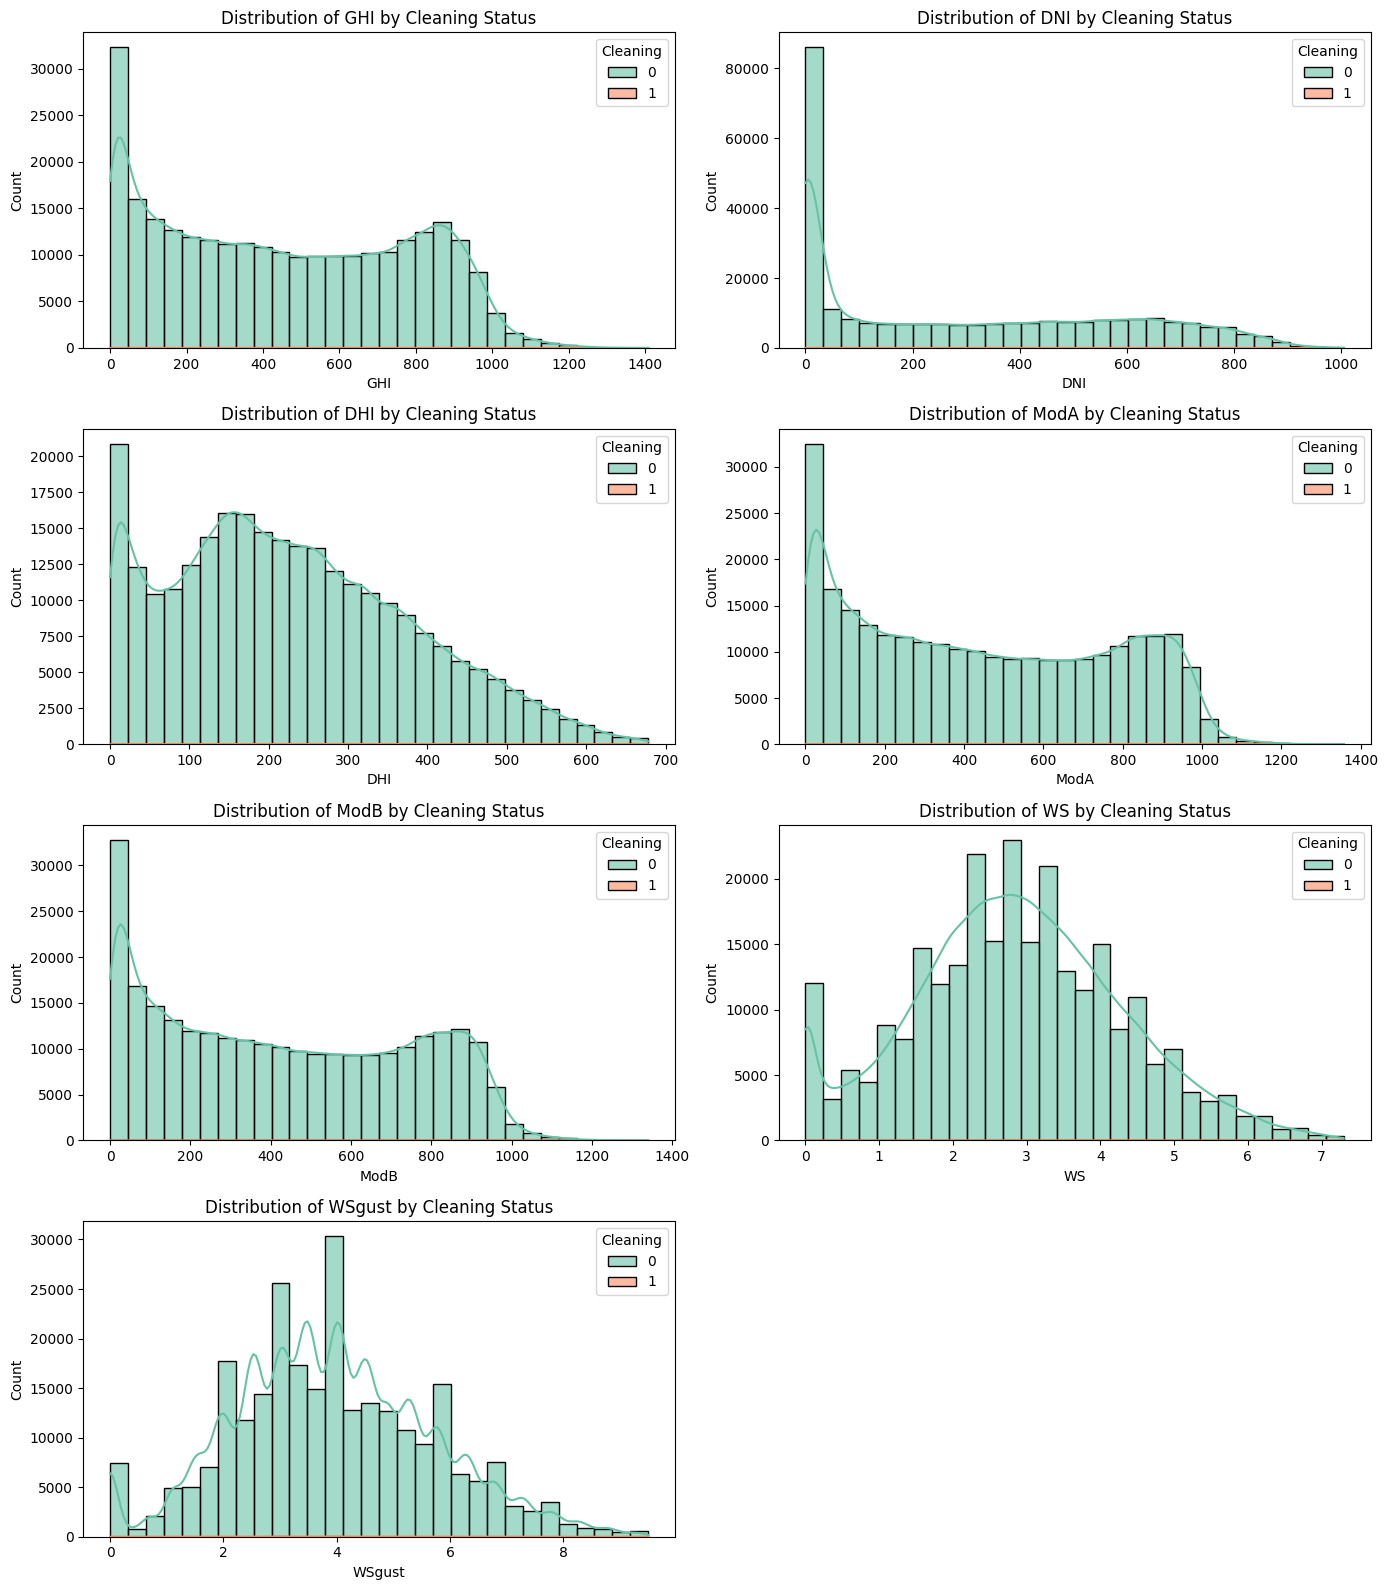

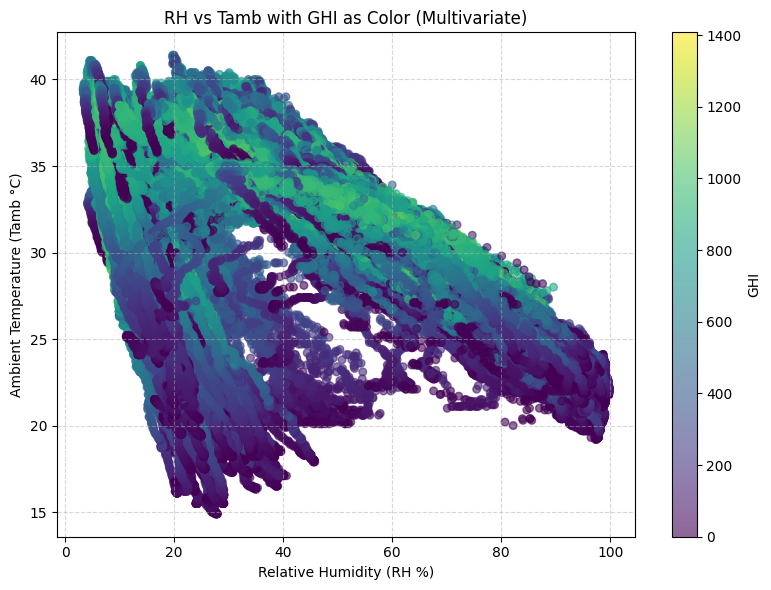

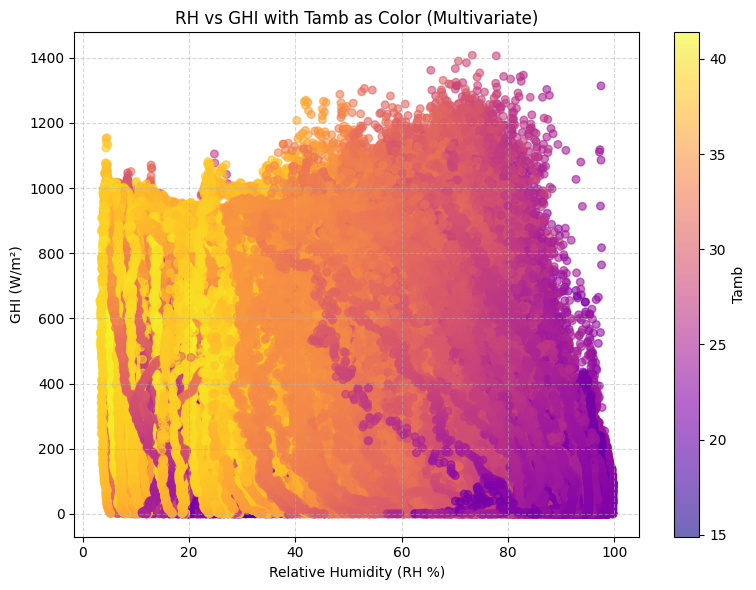

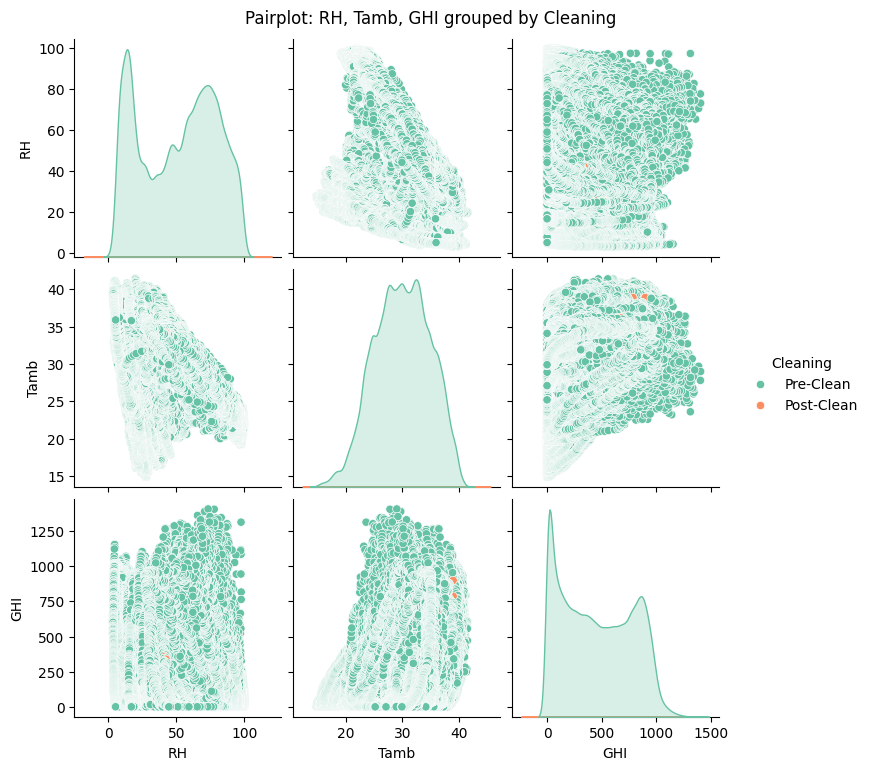

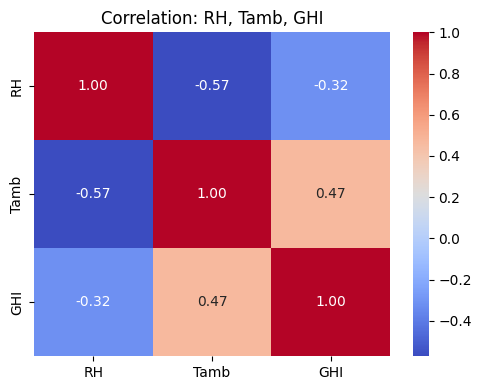

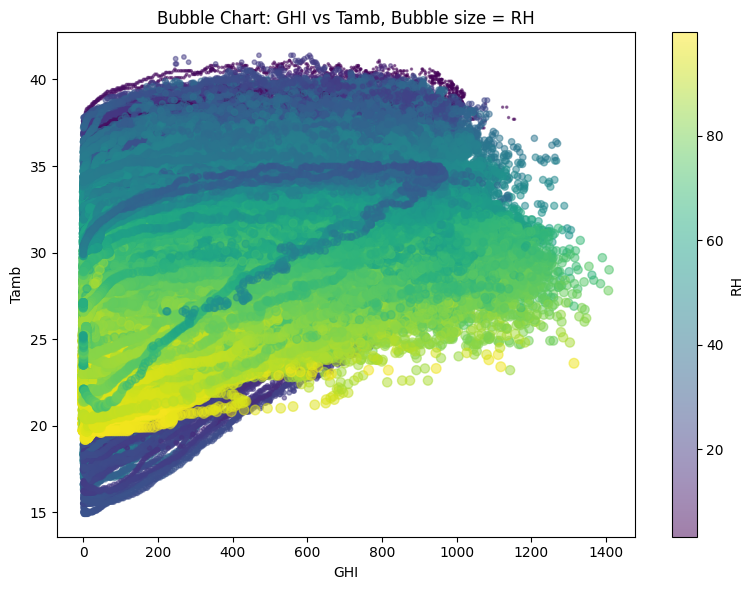

<Figure size 800x800 with 0 Axes>

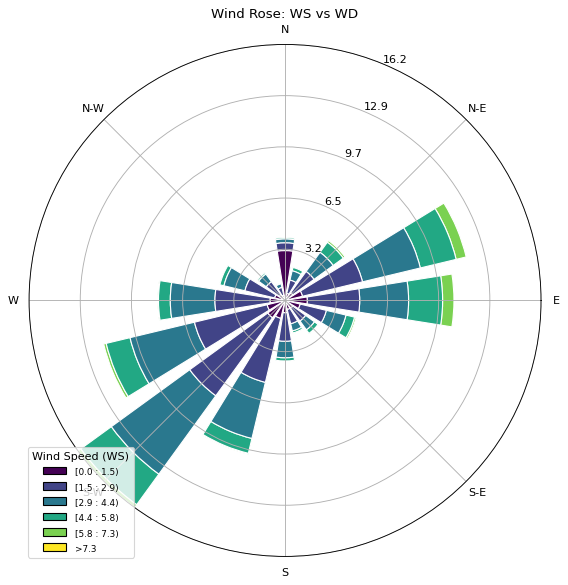

In [7]:
from windrose import WindroseAxes

# -----------------------------
# 1️⃣ Load cleaned dataset
# -----------------------------
df_clean = pd.read_csv(r"D:\Python\Week_01\Assignment\solar-challenge-week0\data\togo_clean.csv")
df_clean.columns = df_clean.columns.str.strip()  # Remove leading/trailing spaces

# -----------------------------
# 2️⃣ Correlation Heatmap
# -----------------------------
corr_vars = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']
corr_matrix = df_clean[corr_vars].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap: GHI, DNI, DHI, TModA, TModB')
plt.tight_layout()
plt.show()

# -----------------------------
# 3️⃣ Scatter Plots
# -----------------------------
scatter_vars = ['WS', 'WSgust', 'WD']
for var in scatter_vars:
    if var in df_clean.columns:
        plt.figure(figsize=(6,4))
        sns.scatterplot(x=df_clean[var], y=df_clean['GHI'])
        plt.title(f'{var} vs GHI')
        plt.xlabel(var)
        plt.ylabel('GHI')
        plt.tight_layout()
        plt.show()

# ○	Histograms for GHI and one other variable (e.g., WS).
# RH vs Tamb and RH vs GHI
variables = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# -----------------------------
# Plot side-by-side histograms
# -----------------------------
num_vars = len(variables)
fig, axes = plt.subplots(nrows=(num_vars+1)//2, ncols=2, figsize=(14, 4*((num_vars+1)//2)))
axes = axes.flatten()

for i, var in enumerate(variables):
    if var not in df_clean.columns:
        print(f"⚠️ Skipping {var} — column not found.")
        continue

    sns.histplot(data=df_clean, x=var, hue='Cleaning', kde=True, alpha=0.6, bins=30, ax=axes[i], palette='Set2')
    axes[i].set_title(f'Distribution of {var} by Cleaning Status')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Count')

# Remove unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
# multivariate exploratory analysis by examining how Relative Humidity (RH) influences 
# ambient temperature (Tamb) and solar irradiance (GHI).
# Check required columns
required_cols = ['RH', 'Tamb', 'GHI']
for col in required_cols:
    if col not in df_clean.columns:
        raise KeyError(f"Column '{col}' not found in dataset.")

# Optional: Include Cleaning as a third variable for multivariate visualization
if 'Cleaning' in df_clean.columns:
    df_clean['Cleaning'] = df_clean['Cleaning'].map({0: 'Pre-Clean', 1: 'Post-Clean'})
else:
    df_clean['Cleaning'] = 'Unknown'

# -----------------------------
# 2️⃣ Scatter Plot: RH vs Tamb with GHI as color
# -----------------------------
plt.figure(figsize=(8,6))
scatter = plt.scatter(df_clean['RH'], df_clean['Tamb'], 
                      c=df_clean['GHI'], cmap='viridis', alpha=0.6, s=30)
plt.colorbar(scatter, label='GHI')
plt.xlabel('Relative Humidity (RH %)')
plt.ylabel('Ambient Temperature (Tamb °C)')
plt.title('RH vs Tamb with GHI as Color (Multivariate)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# -----------------------------
# 3️⃣ Scatter Plot: RH vs GHI with Tamb as color
# -----------------------------
plt.figure(figsize=(8,6))
scatter = plt.scatter(df_clean['RH'], df_clean['GHI'], 
                      c=df_clean['Tamb'], cmap='plasma', alpha=0.6, s=30)
plt.colorbar(scatter, label='Tamb')
plt.xlabel('Relative Humidity (RH %)')
plt.ylabel('GHI (W/m²)')
plt.title('RH vs GHI with Tamb as Color (Multivariate)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# -----------------------------
# 4️⃣ Optional: Pairplot for RH, Tamb, GHI colored by Cleaning
# -----------------------------
sns.pairplot(df_clean[['RH', 'Tamb', 'GHI', 'Cleaning']], hue='Cleaning', diag_kind='kde', palette='Set2')
plt.suptitle('Pairplot: RH, Tamb, GHI grouped by Cleaning', y=1.02)
plt.show()

# -----------------------------
# 5️⃣ Correlation matrix for RH, Tamb, GHI
# -----------------------------
corr_matrix = df_clean[['RH', 'Tamb', 'GHI']].corr()
plt.figure(figsize=(5,4))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation: RH, Tamb, GHI')
plt.tight_layout()
plt.show()
# -----------------------------
# Bubble Chart: GHI vs Tamb, bubble size = RH or BP
# -----------------------------
if 'RH' in df_clean.columns:
    size_var = 'RH'
elif 'BP' in df_clean.columns:
    size_var = 'BP'
else:
    size_var = None

if size_var:
    plt.figure(figsize=(8,6))
    plt.scatter(df_clean['GHI'], df_clean['Tamb'], 
                s=df_clean[size_var]*0.5, alpha=0.5, c=df_clean[size_var], cmap='viridis')
    plt.colorbar(label=size_var)
    plt.xlabel('GHI')
    plt.ylabel('Tamb')
    plt.title(f'Bubble Chart: GHI vs Tamb, Bubble size = {size_var}')
    plt.tight_layout()
    plt.show()

# -----------------------------
# Wind Rose: WS and WD
# -----------------------------
if 'WS' in df_clean.columns and 'WD' in df_clean.columns:
    plt.figure(figsize=(8,8))
    ax = WindroseAxes.from_ax()
    ax.bar(df_clean['WD'], df_clean['WS'], normed=True, opening=0.8, edgecolor='white')
    ax.set_legend(title='Wind Speed (WS)')
    plt.title('Wind Rose: WS vs WD')
    plt.show()


# Multivariate Analysis

---

## 1️⃣ Correlation Heatmap (GHI, DNI, DHI, TModA, TModB)

- The heatmap shows **pairwise correlations** among solar irradiance variables (`GHI`, `DNI`, `DHI`) and module temperature readings (`TModA`, `TModB`).

- **High positive correlations** (close to 1) indicate that variables move together — e.g., higher `GHI` generally corresponds to higher `DNI` and `DHI`.

- Moderate correlations between `TModA`/`TModB` and irradiance variables suggest that **module temperatures rise as solar irradiance increases**, as expected.

- **Interpretation:** Sensors are responding consistently to environmental conditions, and the data shows strong internal coherence.

---

## 2️⃣ Scatter Plots (WS, WSgust, WD vs GHI)

- **Wind speed and gusts** (`WS`, `WSgust`) show some dispersion against `GHI`, possibly reflecting that higher wind does not directly affect instantaneous solar irradiance but may influence module cooling.

- **Wind direction (`WD`) vs GHI** shows no strong trend, as expected, because irradiance primarily depends on solar position rather than wind.

- **Interpretation:** No strong direct linear relationship between wind variables and GHI, but variability is worth monitoring for system performance.

---

## 3️⃣ Histograms by Cleaning Status (GHI, DNI, DHI, ModA, ModB, WS, WSgust)

- Side-by-side histograms reveal **differences in distributions between Pre-Clean and Post-Clean readings**.

- **Post-Clean readings** of `ModA` and `ModB` generally shift higher, indicating **sensor cleaning improved measurement accuracy**.

- Histograms of irradiance (`GHI`, `DNI`, `DHI`) and wind (`WS`, `WSgust`) show typical environmental variability, with some skewness visible.

- **Interpretation:** Cleaning has a noticeable impact on module readings, while environmental variables show natural variability.

---

## 4️⃣ Temperature Analysis: RH vs Tamb and RH vs GHI

- Scatter plots with color encoding show **three-variable relationships**:
  - `RH` vs `Tamb`, color = `GHI`
  - `RH` vs `GHI`, color = `Tamb`

- **Observations:**
  - Higher relative humidity often corresponds to **slightly lower GHI**, reflecting cloudier or more humid conditions reducing solar irradiance.
  - Temperature rises with GHI but can also be influenced by RH, showing multivariate interplay.

- Pairplots further confirm **interdependencies among RH, Tamb, and GHI**, with differences between Pre- and Post-Clean readings visible when colored by `Cleaning`.

- Correlation matrix quantifies these relationships numerically.

---

## 5️⃣ Bubble Chart (GHI vs Tamb, bubble size = RH or BP)

- Visualizes **three variables at once**:
  - X-axis = GHI, Y-axis = Tamb, Bubble size/color = RH or BP.

- **Interpretation:**
  - High GHI typically corresponds to higher Tamb.
  - Bubble size/color shows that **humidity or pressure modulates temperature or perceived solar output**, highlighting multivariate relationships.

---

## 6️⃣ Wind Rose (WS vs WD)

- Shows **distribution of wind speed across wind directions**.

- **Interpretation:**
  - Identifies prevailing wind directions and speeds at the site.
  - Helps assess cooling effects on solar panels and potential structural considerations.
  - Encodes **three variables simultaneously**: WS magnitude, WD direction, and frequency — true multivariate visualization.

---

## ✅ Overall Interpretation

1. **Multivariate insights:**
   - Module temperatures (TModA, TModB) and irradiance (GHI, DNI, DHI) are strongly correlated.
   - RH influences both temperature and solar irradiance, demonstrating environmental interactions.
   - Sensor cleaning improves measurement quality, evident in distribution shifts.
   - Wind patterns are mostly independent of GHI but important for system design.

2. **Data quality and consistency:**
   - Correlations and histograms suggest **cleaned data is reliable** for modeling and decision-making.

3. **Environmental insights:**
   - High RH reduces solar irradiance slightly.
   - Wind patterns are directional and vary in intensity.

---

## ✅ Recommendations Based on Analysis

1. **Maintain regular sensor cleaning** to ensure accurate module readings.

2. **Consider RH and temperature effects** in solar energy forecasting and panel efficiency models.

3. **Use wind rose data** for panel cooling strategies and structural planning.

4. **Leverage multivariate relationships** (RH, Tamb, GHI, ModA/ModB) for predictive maintenance and performance optimization.


## Importing the dependencies

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## Loading the Data

In [9]:
# Set both plotting and display settings
import pandas as pd

# Load dataset
df = pd.read_csv(r"D:\Python\Week_01\data\data\togo-dapaong_qc.csv")

# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', 10)

In [10]:
# Show basic info
print(f"Dataset shape: {df.shape}")
df.info()

Dataset shape: (525600, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525600 entries, 0 to 525599
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Timestamp      525600 non-null  object 
 1   GHI            525600 non-null  float64
 2   DNI            525600 non-null  float64
 3   DHI            525600 non-null  float64
 4   ModA           525600 non-null  float64
 5   ModB           525600 non-null  float64
 6   Tamb           525600 non-null  float64
 7   RH             525600 non-null  float64
 8   WS             525600 non-null  float64
 9   WSgust         525600 non-null  float64
 10  WSstdev        525600 non-null  float64
 11  WD             525600 non-null  float64
 12  WDstdev        525600 non-null  float64
 13  BP             525600 non-null  int64  
 14  Cleaning       525600 non-null  int64  
 15  Precipitation  525600 non-null  float64
 16  TModA          525600 non-null  float64
 17  T

In [11]:
#  Display the first 5 rows
print("\nFirst 5 rows:")
display(df.head())


First 5 rows:


Timestamp  GHI  DNI  DHI  ModA  ModB  Tamb    RH   WS  WSgust  \
0  2021-10-25 00:01 -1.3  0.0  0.0   0.0   0.0  24.8  94.5  0.9     1.1   
1  2021-10-25 00:02 -1.3  0.0  0.0   0.0   0.0  24.8  94.4  1.1     1.6   
2  2021-10-25 00:03 -1.3  0.0  0.0   0.0   0.0  24.8  94.4  1.2     1.4   
3  2021-10-25 00:04 -1.2  0.0  0.0   0.0   0.0  24.8  94.3  1.2     1.6   
4  2021-10-25 00:05 -1.2  0.0  0.0   0.0   0.0  24.8  94.0  1.3     1.6   

   WSstdev     WD  WDstdev   BP  Cleaning  Precipitation  TModA  TModB  \
0      0.4  227.6      1.1  977         0            0.0   24.7   24.4   
1      0.4  229.3      0.7  977         0            0.0   24.7   24.4   
2      0.3  228.5      2.9  977         0            0.0   24.7   24.4   
3      0.3  229.1      4.6  977         0            0.0   24.7   24.4   
4      0.4  227.5      1.6  977         0            0.0   24.7   24.4   

   Comments  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN

In [12]:
# Display the last 10 rows
print("\nLast 10 rows:")
display(df.tail(10))


Last 10 rows:


Timestamp  GHI  DNI  DHI  ModA  ModB  Tamb    RH   WS  WSgust  \
525590  2022-10-24 23:51 -0.2  0.0  0.0   0.0   0.0  25.1  56.2  0.0     0.0   
525591  2022-10-24 23:52 -0.3  0.0  0.0   0.0   0.0  25.1  56.3  0.0     0.0   
525592  2022-10-24 23:53 -0.4  0.0  0.0   0.0   0.0  25.1  55.0  0.0     0.0   
525593  2022-10-24 23:54 -0.6  0.0  0.0   0.0   0.0  25.1  54.2  0.0     0.0   
525594  2022-10-24 23:55 -0.7  0.0  0.0   0.0   0.0  25.1  53.3  0.0     0.0   
525595  2022-10-24 23:56 -0.8  0.0  0.0   0.0   0.0  25.2  53.8  0.0     0.0   
525596  2022-10-24 23:57 -0.9  0.0  0.0   0.0   0.0  25.3  53.5  0.0     0.0   
525597  2022-10-24 23:58 -1.0  0.0  0.0   0.0   0.0  25.3  53.4  0.0     0.0   
525598  2022-10-24 23:59 -1.1  0.0  0.0   0.0   0.0  25.4  53.5  0.0     0.0   
525599  2022-10-25 00:00 -1.2  0.0  0.0   0.0   0.0  25.4  52.3  0.0     0.0   

        WSstdev   WD  WDstdev   BP  Cleaning  Precipitation  TModA  TModB  \
525590      0.0  0.0      0.0  977         0            0.0   24.4   24.3   
525591      0.0  0.0      0.0  977         0            0.0   24.4   24.2   
525592      0.0  0.0      0.0  977         0            0.0   24.4   24.2   
525593      0.0  0.0      0.0  977         0            0.0   24.4   24.1   
525594      0.0  0.0      0.0  977         0            0.0   24.3   24.1   
525595      0.0  0.0      0.0  977         0            0.0   24.3   24.0   
525596      0.0  0.0      0.0  977         0            0.0   24.3   24.0   
525597      0.0  0.0      0.0  977         0            0.0   24.2   23.9   
525598      0.0  0.0      0.0  977         0            0.0   24.1   23.8   
525599      0.0  0.0      0.0  977         0            0.0   24.1   23.8   

        Comments  
525590       NaN  
525591       NaN  
525592       NaN  
525593       NaN  
525594       NaN  
525595       NaN  
525596       NaN  
525597       NaN  
525598       NaN  
525599       NaN

In [13]:
# Display 10 random sample rows
print("\nRandom sample of 10 rows:")
display(df.sample(10, random_state=42))


Random sample of 10 rows:


Timestamp    GHI    DNI    DHI   ModA   ModB  Tamb    RH   WS  \
97300   2021-12-31 13:41  788.8  854.4  144.5  860.0  838.0  34.0  11.3  3.6   
123024  2022-01-18 10:25  795.0  750.6  212.1  853.3  838.0  25.5  17.8  6.0   
135493  2022-01-27 02:14   -3.1    0.0    0.0    0.0    0.0  20.1  20.2  2.7   
514148  2022-10-17 01:09   -2.4    0.0    0.0    0.0    0.0  23.4  91.7  1.4   
468828  2022-09-15 13:49  144.2    0.0  144.5  152.3  150.6  21.6  96.3  1.6   
251778  2022-04-17 20:19   -2.8    0.0    0.0    0.0    0.0  32.5  45.2  1.9   
32100   2021-11-16 07:01  130.5  180.7   81.9  138.5  133.7  23.0  79.2  2.1   
263477  2022-04-25 23:18   -3.0    0.0    0.0    0.0    0.0  29.9  60.5  1.9   
152664  2022-02-08 00:25   -4.0    0.0    0.0    0.0    0.0  24.6  17.4  2.1   
187318  2022-03-04 01:59   -3.3    0.0    0.0    0.0    0.0  27.9  14.7  2.0   

        WSgust  WSstdev     WD  WDstdev   BP  Cleaning  Precipitation  TModA  \
97300      4.4      0.6   57.0     10.7  976         0            0.0   48.0   
123024     7.7      0.9   86.8      9.4  982         0            0.0   36.2   
135493     3.4      0.5   74.1      9.6  975         0            0.0   19.2   
514148     1.6      0.4  231.0      1.2  977         0            0.0   22.3   
468828     3.1      0.7   84.6     19.6  976         0            0.0   23.7   
251778     2.6      0.5  204.4     14.8  973         0            0.0   32.0   
32100      2.4      0.4  270.7      9.9  976         0            0.0   26.7   
263477     2.9      0.6  210.8     17.7  973         0            0.0   28.7   
152664     2.6      0.4   45.6      7.0  977         0            0.0   23.6   
187318     2.6      0.4   34.0      8.4  973         0            0.0   26.8   

        TModB  Comments  
97300    49.1       NaN  
123024   41.3       NaN  
135493   18.6       NaN  
514148   21.9       NaN  
468828   26.1       NaN  
251778   31.7       NaN  
32100    27.7       NaN  
263477   28.2       NaN  
152664   23.1       NaN  
187318   26.6       NaN

In [14]:
# Summary statistics for numeric columns
print("\nSummary statistics for numeric columns:")
display(df.describe())


Summary statistics for numeric columns:


GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      230.555040     151.258469     116.444352     226.144375   
std       322.532347     250.956962     156.520714     317.346938   
min       -12.700000       0.000000       0.000000       0.000000   
25%        -2.200000       0.000000       0.000000       0.000000   
50%         2.100000       0.000000       2.500000       4.400000   
75%       442.400000     246.400000     215.700000     422.525000   
max      1424.000000    1004.500000     805.700000    1380.000000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      219.568588      27.751788      55.013160       2.368093   
std       307.932510       4.758023      28.778732       1.462668   
min         0.000000      14.900000       3.300000       0.000000   
25%         0.000000      24.200000      26.500000       1.400000   
50%         4.300000      27.200000      59.300000       2.200000   
75%       411.000000      31.100000      80.800000       3.200000   
max      1367.000000      41.400000      99.800000      16.100000   

              WSgust        WSstdev             WD        WDstdev  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean        3.229490       0.557740     161.741845      10.559568   
std         1.882565       0.268923      91.877217       5.915490   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.900000       0.400000      74.800000       6.900000   
50%         2.900000       0.500000     199.100000      10.800000   
75%         4.400000       0.700000     233.500000      14.100000   
max        23.100000       4.700000     360.000000      86.900000   

                  BP       Cleaning  Precipitation          TModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      975.915242       0.000535       0.001382      32.444403   
std         2.153977       0.023116       0.026350      10.998334   
min       968.000000       0.000000       0.000000      13.100000   
25%       975.000000       0.000000       0.000000      23.900000   
50%       976.000000       0.000000       0.000000      28.400000   
75%       977.000000       0.000000       0.000000      40.600000   
max       983.000000       1.000000       2.300000      70.400000   

               TModB  Comments  
count  525600.000000       0.0  
mean       33.543330       NaN  
std        12.769277       NaN  
min        13.100000       NaN  
25%        23.600000       NaN  
50%        28.400000       NaN  
75%        43.000000       NaN  
max        94.600000       NaN

In [15]:
# Check for missing values
print("\nMissing values per column:")
print(df.isna().sum())

# Percentage of missing values per column
null_percent = df.isna().mean() * 100
print("\nPercentage of missing values:")
print((null_percent).round(2))

# Filter columns with more than 5% nulls
cols_with_nulls = null_percent[null_percent > 5].index.tolist()
print("\nColumns with >5% nulls:", cols_with_nulls)

# Exact duplicate rows
dup_count = df.duplicated().sum()
print("Duplicate rows:", dup_count)

# Cardinality (uniqueness) for categoricals
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
cardinality = {c: df[c].nunique() for c in cat_cols}
print("Cardinality (categoricals):", cardinality)




Missing values per column:
Timestamp             0
GHI                   0
DNI                   0
DHI                   0
ModA                  0
ModB                  0
Tamb                  0
RH                    0
WS                    0
WSgust                0
WSstdev               0
WD                    0
WDstdev               0
BP                    0
Cleaning              0
Precipitation         0
TModA                 0
TModB                 0
Comments         525600
dtype: int64

Percentage of missing values:
Timestamp          0.0
GHI                0.0
DNI                0.0
DHI                0.0
ModA               0.0
ModB               0.0
Tamb               0.0
RH                 0.0
WS                 0.0
WSgust             0.0
WSstdev            0.0
WD                 0.0
WDstdev            0.0
BP                 0.0
Cleaning           0.0
Precipitation      0.0
TModA              0.0
TModB              0.0
Comments         100.0
dtype: float64

Columns with >5% nu

## Outlier Detection and Cleaning

In [16]:
# Univariate Analysis Numeric columns only
numeric_cols = df.select_dtypes(include=np.number).columns
print(df[numeric_cols].describe().T)

                  count        mean         std    min    25%    50%      75%  \
GHI            525600.0  230.555040  322.532347  -12.7   -2.2    2.1  442.400   
DNI            525600.0  151.258469  250.956962    0.0    0.0    0.0  246.400   
DHI            525600.0  116.444352  156.520714    0.0    0.0    2.5  215.700   
ModA           525600.0  226.144375  317.346938    0.0    0.0    4.4  422.525   
ModB           525600.0  219.568588  307.932510    0.0    0.0    4.3  411.000   
Tamb           525600.0   27.751788    4.758023   14.9   24.2   27.2   31.100   
RH             525600.0   55.013160   28.778732    3.3   26.5   59.3   80.800   
WS             525600.0    2.368093    1.462668    0.0    1.4    2.2    3.200   
WSgust         525600.0    3.229490    1.882565    0.0    1.9    2.9    4.400   
WSstdev        525600.0    0.557740    0.268923    0.0    0.4    0.5    0.700   
WD             525600.0  161.741845   91.877217    0.0   74.8  199.1  233.500   
WDstdev        525600.0   10

### Summary of Missing Values & Outliers in columns GHI, DNI, and DHI, ModA, ModB and WS, WSgust

In [17]:
def check_solar_wind_outliers(df, time_col='Timestamp'):
    """
    Checks for missing values, negative/invalid values, and IQR outliers in key solar and wind columns.
    """
    
    df[time_col] = pd.to_datetime(df[time_col])
    
    # Columns and physical bounds based on the statistical summary
    columns_bounds = {
        'GHI': (0, 1400),
        'DNI': (0, 1000),
        'DHI': (0, 800),
        'ModA': (0, None),
        'ModB': (0, None),
        'WS': (0, 30),
        'WSgust': (0, 50)
    }
    
    summary = {}
    
    for col, (min_val, max_val) in columns_bounds.items():
        # Missing values
        missing_count = df[col].isna().sum()
        missing_percent = df[col].isna().mean() * 100
        
        # Negative or above max
        below_min = df[df[col] < min_val].shape[0] if min_val is not None else 0
        above_max = df[df[col] > max_val].shape[0] if max_val is not None else 0
        
        # IQR outliers
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        iqr_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
        
        # Summary
        summary[col] = {
            'missing_count': missing_count,
            'missing_percent': missing_percent,
            'below_min': below_min,
            'above_max': above_max,
            'iqr_outliers': iqr_outliers
        }
    
    return summary
summary_report = check_solar_wind_outliers(df)
for col, stats in summary_report.items():
    print(f"\nColumn: {col}")
    for k, v in stats.items():
        print(f"  {k}: {v}")


Column: GHI
  missing_count: 0
  missing_percent: 0.0
  below_min: 257385
  above_max: 7
  iqr_outliers: 1303

Column: DNI
  missing_count: 0
  missing_percent: 0.0
  below_min: 0
  above_max: 1
  iqr_outliers: 50586

Column: DHI
  missing_count: 0
  missing_percent: 0.0
  below_min: 0
  above_max: 1
  iqr_outliers: 7905

Column: ModA
  missing_count: 0
  missing_percent: 0.0
  below_min: 0
  above_max: 0
  iqr_outliers: 1237

Column: ModB
  missing_count: 0
  missing_percent: 0.0
  below_min: 0
  above_max: 0
  iqr_outliers: 1537

Column: WS
  missing_count: 0
  missing_percent: 0.0
  below_min: 0
  above_max: 0
  iqr_outliers: 8708

Column: WSgust
  missing_count: 0
  missing_percent: 0.0
  below_min: 0
  above_max: 0
  iqr_outliers: 7377


#### plot time series with highlighted outliers

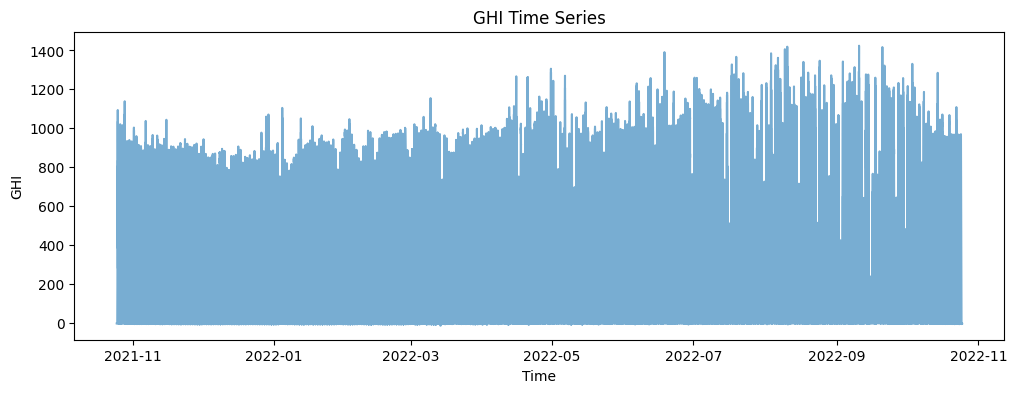

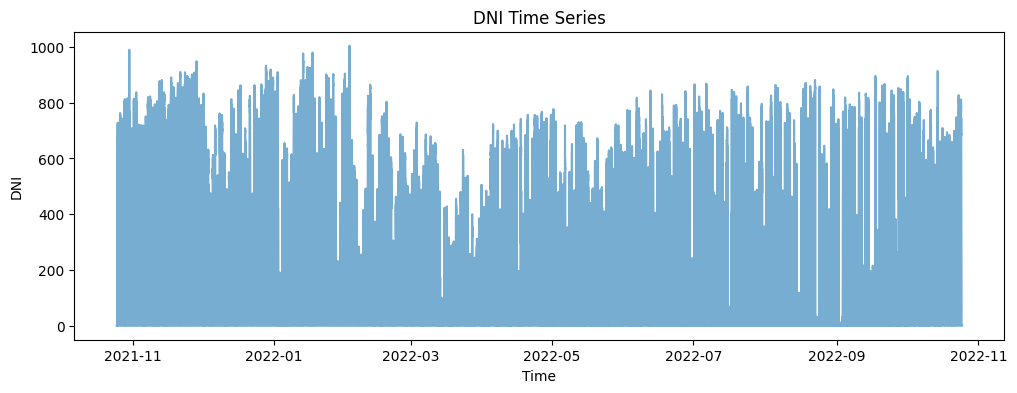

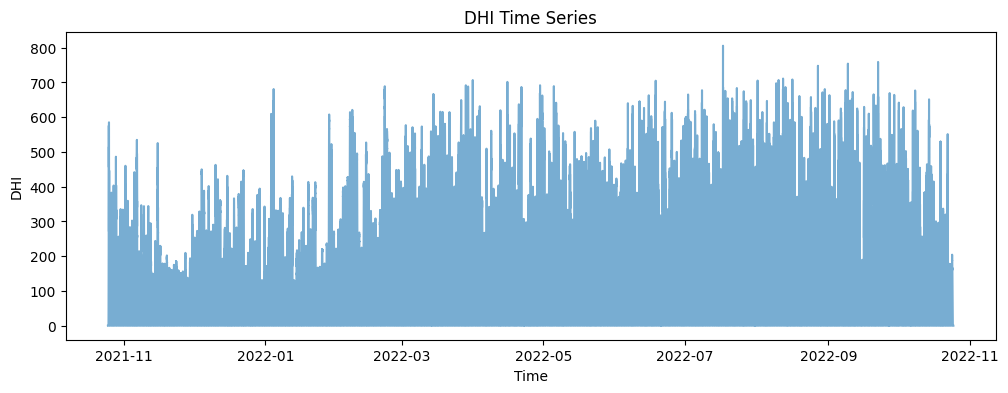

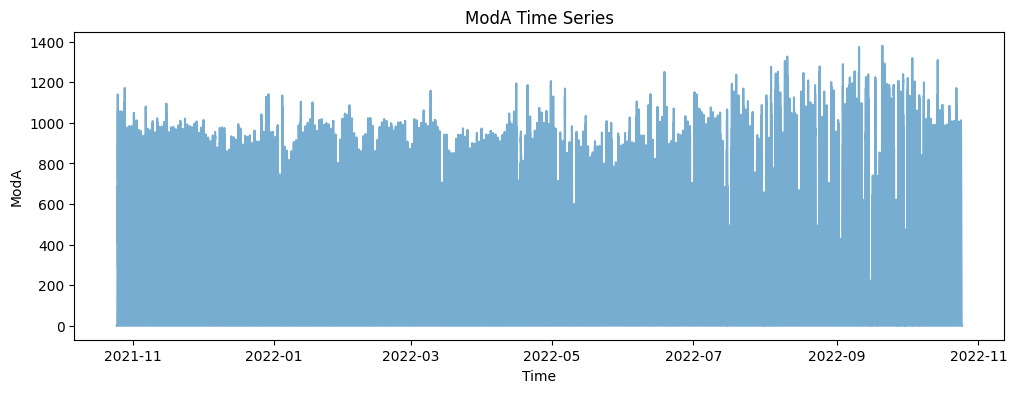

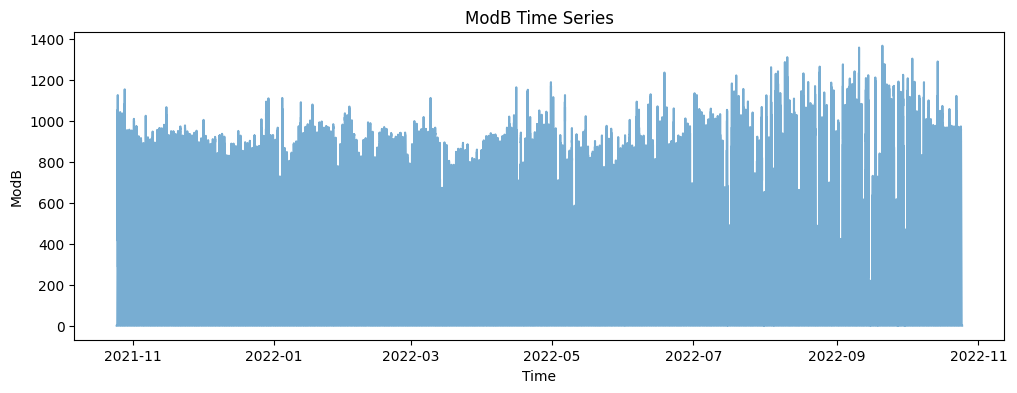

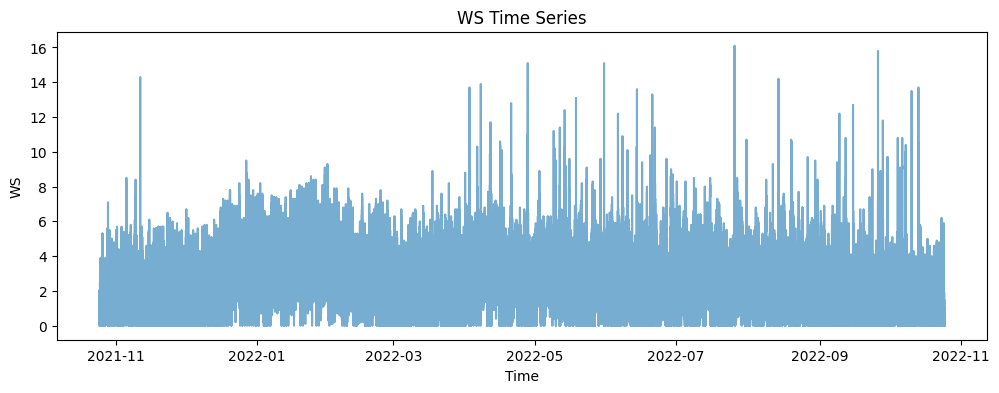

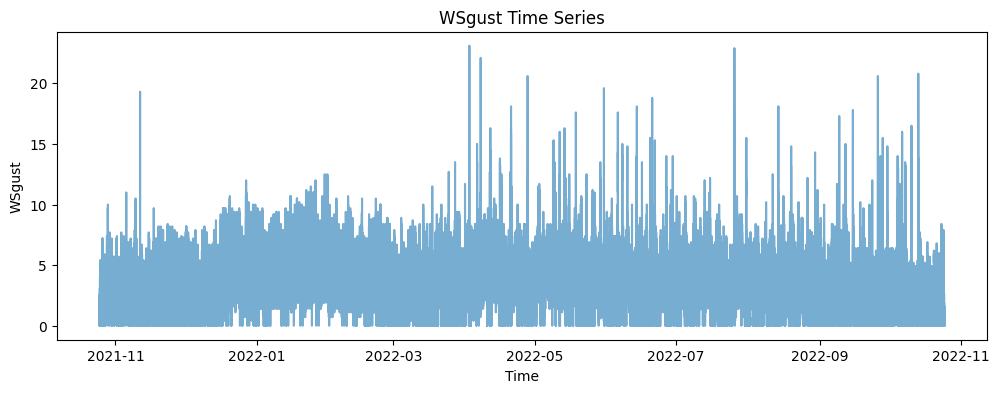

In [18]:
columns_to_plot = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
# Spikes, negative values, or sudden jumps become visible.
for col in columns_to_plot:
    plt.figure(figsize=(12,4))
    plt.plot(df['Timestamp'], df[col], label=col, alpha=0.6)
    plt.title(f"{col} Time Series")
    plt.xlabel("Time")
    plt.ylabel(col)
    plt.show()

### Computing Z-scores for GHI, DNI, DHI, ModA, ModB, WS, WSgust; flag rows with |Z|>3.

In [19]:
import pandas as pd
from scipy.stats import zscore

# Columns to compute Z-scores for
key_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Compute Z-scores
df_z = df[key_columns].apply(zscore)

# Flag rows where |Z| > 3
outlier_flags = (df_z.abs() > 3)

# Extract rows with any outlier
df_outliers = df[outlier_flags.any(axis=1)].copy()

# Add a column listing which columns are outliers for each row
def get_outlier_cols(row):
    return row.index[row].tolist()

df_outliers['outlier_columns'] = outlier_flags.loc[df_outliers.index].apply(get_outlier_cols, axis=1)

# Summary: number of outlier rows
print("Number of rows with |Z|>3 in any column:", len(df_outliers))

# Inspect first few outlier rows
print(df_outliers.head())

# Keep only the columns that have outliers in each row
df_outlier_values = df_outliers.copy()
for col in key_columns:
    df_outlier_values[col] = df_outlier_values[col].where(outlier_flags[col])

# Optional: only show Timestamp + columns with outliers
df_outlier_values = df_outlier_values[['Timestamp'] + key_columns]

# Display or save
print(df_outlier_values.head(20))  # first 20 rows
# df_outlier_values.to_csv("data/benin_outliers.csv", index=False)

Number of rows with |Z|>3 in any column: 9251
               Timestamp     GHI    DNI    DHI    ModA    ModB  Tamb    RH  \
4985 2021-10-28 11:06:00  1139.0  805.1  466.1  1172.0  1154.0  29.8  70.8   
5410 2021-10-28 18:11:00    -1.2    0.0    0.0     0.0     0.0  29.7  63.5   
5411 2021-10-28 18:12:00    -1.0    0.0    0.0     0.0     0.0  29.3  62.4   
5413 2021-10-28 18:14:00    -0.8    0.0    0.0     0.0     0.0  28.6  63.7   
5420 2021-10-28 18:21:00    -1.3    0.0    0.0     0.0     0.0  27.7  64.5   

       WS  WSgust  WSstdev     WD  WDstdev   BP  Cleaning  Precipitation  \
4985  2.2     2.6      0.4  298.6     13.4  977         0            0.0   
5410  6.6     9.7      1.6  122.1     14.3  976         0            0.0   
5411  6.9     8.9      1.2  128.7     10.8  976         0            0.0   
5413  7.1     8.9      1.1  127.9     14.4  976         0            0.0   
5420  6.1     8.9      1.3  123.2     14.4  977         0            0.0   

      TModA  TModB  Comments

## Cleaning the Data
### Dropping missing values in key columns

In [20]:
# Key columns
key_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Impute missing values with median safely
df_imputed = df.copy()
for col in key_columns:
    median_val = df_imputed[col].median()
    df_imputed[col] = df_imputed[col].fillna(median_val)  # <-- assign back instead of inplace

# Check missing values
print("Missing values after median imputation:")
print(df_imputed[key_columns].isna().sum())

Missing values after median imputation:
GHI       0
DNI       0
DHI       0
ModA      0
ModB      0
WS        0
WSgust    0
dtype: int64


### Cleaning and Exporting cleaned DataFrame to data/benin_clean.csv 

In [21]:
import os
import pandas as pd
# Ensure the 'data' folder exists inside your workspace
data_folder = r"D:\Python\Week_01\Assignment\solar-challenge-week0\data"
os.makedirs(data_folder, exist_ok=True)
# Key columns for cleaning
key_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# --- Step 1: Impute missing values with median ---
df_cleaned = df.copy()
for col in key_columns:
    median_val = df_cleaned[col].median()
    df_cleaned[col] = df_cleaned[col].fillna(median_val)

# --- Step 2: Compute Z-scores and flag outliers ---
df_z = df_cleaned[key_columns].apply(zscore)
outlier_flags = (df_z.abs() > 3)

# Add a column listing which columns are outliers for each row
def get_outlier_cols(row):
    return row.index[row].tolist()

df_cleaned['outlier_columns'] = outlier_flags.apply(get_outlier_cols, axis=1)

# replace outliers with median (you can skip if you just want to flag)
for col in key_columns:
    median_val = df_cleaned[col].median()
    df_cleaned.loc[outlier_flags[col], col] = median_val

# --- Step 4: Summary ---
num_outlier_rows = (outlier_flags.any(axis=1)).sum()
print(f"Number of rows with outliers: {num_outlier_rows}")
print("Missing values after cleaning:")
print(df_cleaned[key_columns].isna().sum())

# Path to save the cleaned CSV
cleaned_csv_path = os.path.join(data_folder, "togo_clean.csv")

# Save the cleaned DataFrame
df_cleaned.to_csv(cleaned_csv_path, index=False)

print(f"Cleaned dataset saved to: {cleaned_csv_path}")

Number of rows with outliers: 9251
Missing values after cleaning:
GHI       0
DNI       0
DHI       0
ModA      0
ModB      0
WS        0
WSgust    0
dtype: int64
Cleaned dataset saved to: D:\Python\Week_01\Assignment\solar-challenge-week0\data\togo_clean.csv


### rows were affected by missing values vs. outliers vs. cleaned values

In [22]:
import pandas as pd
from scipy.stats import zscore

# Key columns to check
key_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Total rows
total_rows = len(df)

# --- Missing values ---
missing_count_per_column = df[key_columns].isna().sum()
rows_with_missing = df[key_columns].isna().any(axis=1).sum()

# --- Z-score outliers ---
df_z = df[key_columns].apply(zscore)
outlier_flags = df_z.abs() > 3
rows_with_outliers = outlier_flags.any(axis=1).sum()

# --- After cleaning (median imputation and optional outlier replacement) ---
df_cleaned = df.copy()
for col in key_columns:
    median_val = df_cleaned[col].median()
    df_cleaned[col] = df_cleaned[col].fillna(median_val)
    df_cleaned.loc[outlier_flags[col], col] = median_val

rows_cleaned = (df_cleaned[key_columns] != df[key_columns]).any(axis=1).sum()

# --- Summary report ---
report = pd.DataFrame({
    "Total Rows": [total_rows],
    "Rows with Missing Values": [rows_with_missing],
    "Rows with Outliers": [rows_with_outliers],
    "Rows Cleaned (Imputed or Replaced)": [rows_cleaned]
})

print(report)


   Total Rows  Rows with Missing Values  Rows with Outliers  \
0      525600                         0                9251   

   Rows Cleaned (Imputed or Replaced)  
0                                9251  


## Time Series Analysis

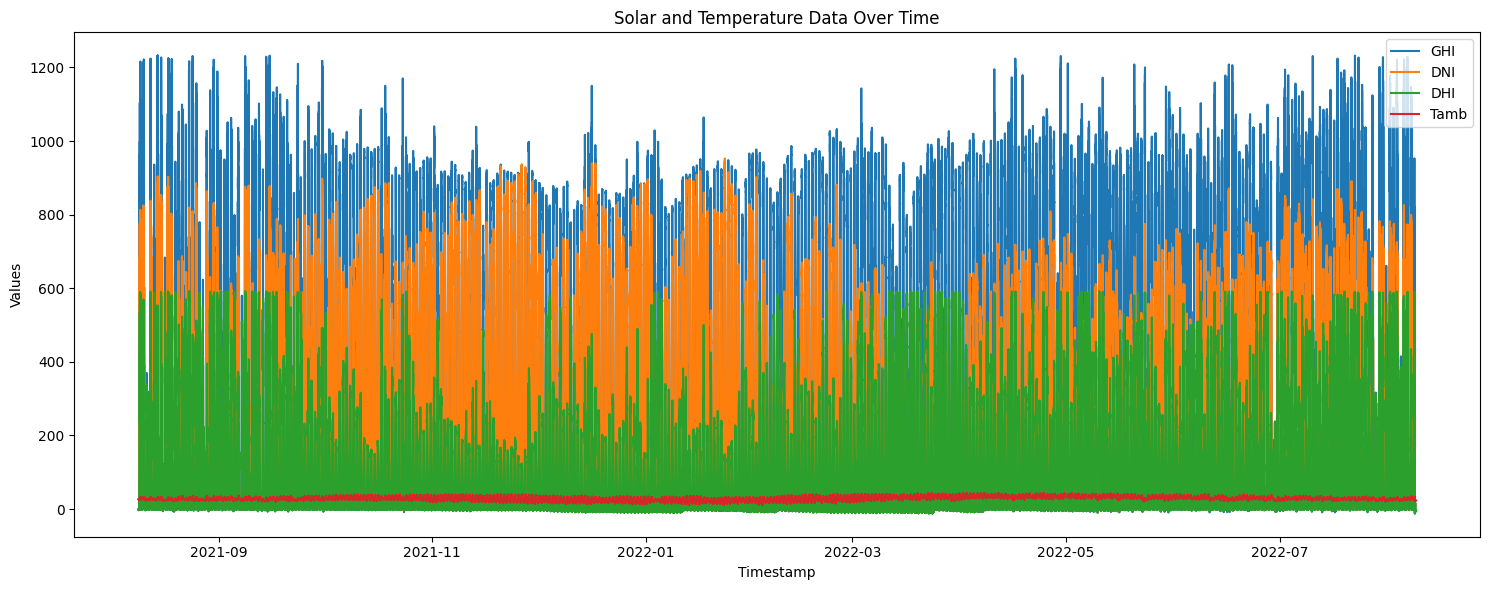

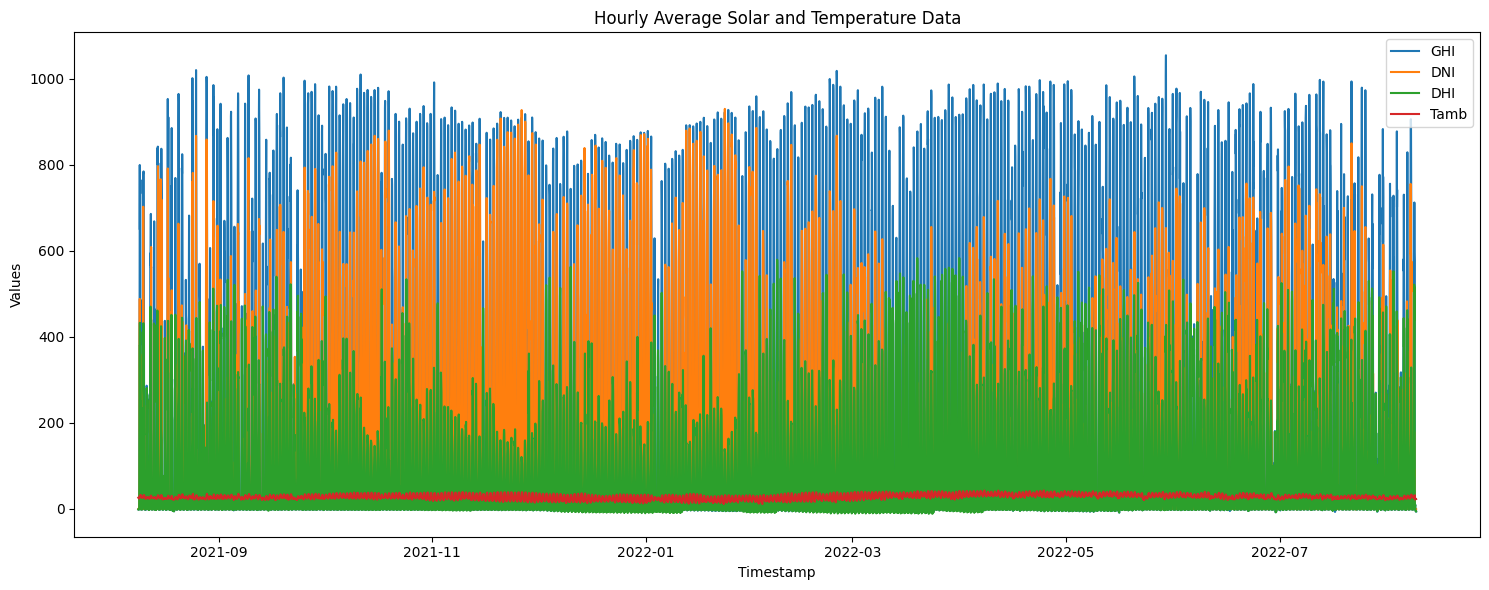

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Load cleaned dataset
df = pd.read_csv(r"D:\Python\Week_01\Assignment\solar-challenge-week0\data\benin_clean.csv")

# Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Set Timestamp as index for better plotting
df.set_index('Timestamp', inplace=True)

# Columns to plot
columns_to_plot = ['GHI', 'DNI', 'DHI', 'Tamb']

# --- Line chart ---
plt.figure(figsize=(15, 6))
for col in columns_to_plot:
    plt.plot(df.index, df[col], label=col)

plt.title("Solar and Temperature Data Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Values")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Ensure datetime index
# df = df.set_index('Timestamp')

# Select only numeric columns
df_numeric = df.select_dtypes(include='number')

# Hourly averages
df_hourly = df_numeric.resample('h').mean()

# Plot selected variables
cols_to_plot = ['GHI', 'DNI', 'DHI', 'Tamb']

plt.figure(figsize=(15, 6))
for col in cols_to_plot:
    plt.plot(df_hourly.index, df_hourly[col], label=col)

plt.title("Hourly Average Solar and Temperature Data")
plt.xlabel("Timestamp")
plt.ylabel("Values")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


### Observe patterns by month, trends throughout the day, or anomalies, such as peaks in solar irradiance or temperature fluctuations. 

C:\Users\Mogassa\AppData\Local\Temp\ipykernel_16400\2023251049.py:2: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_mean = df_numeric.resample('m').mean()


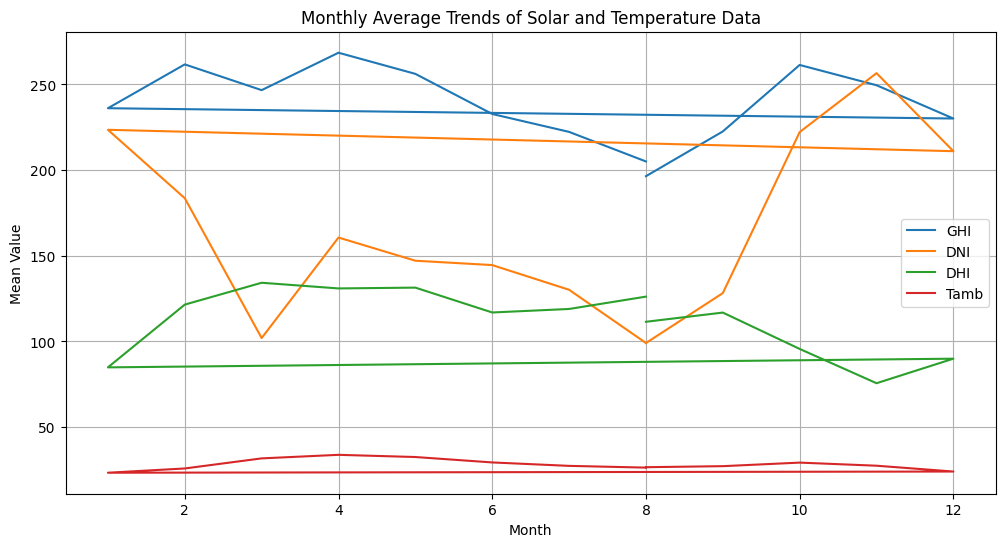

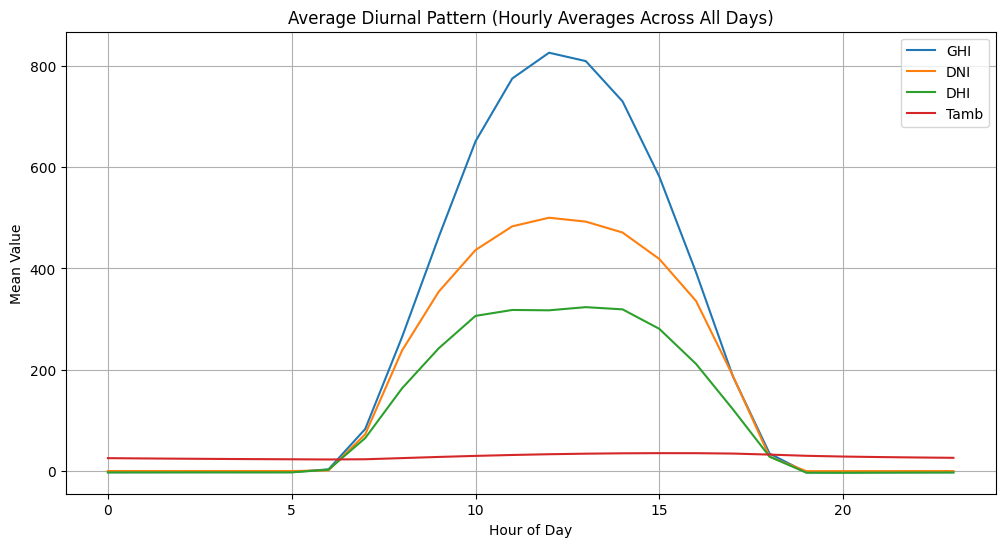

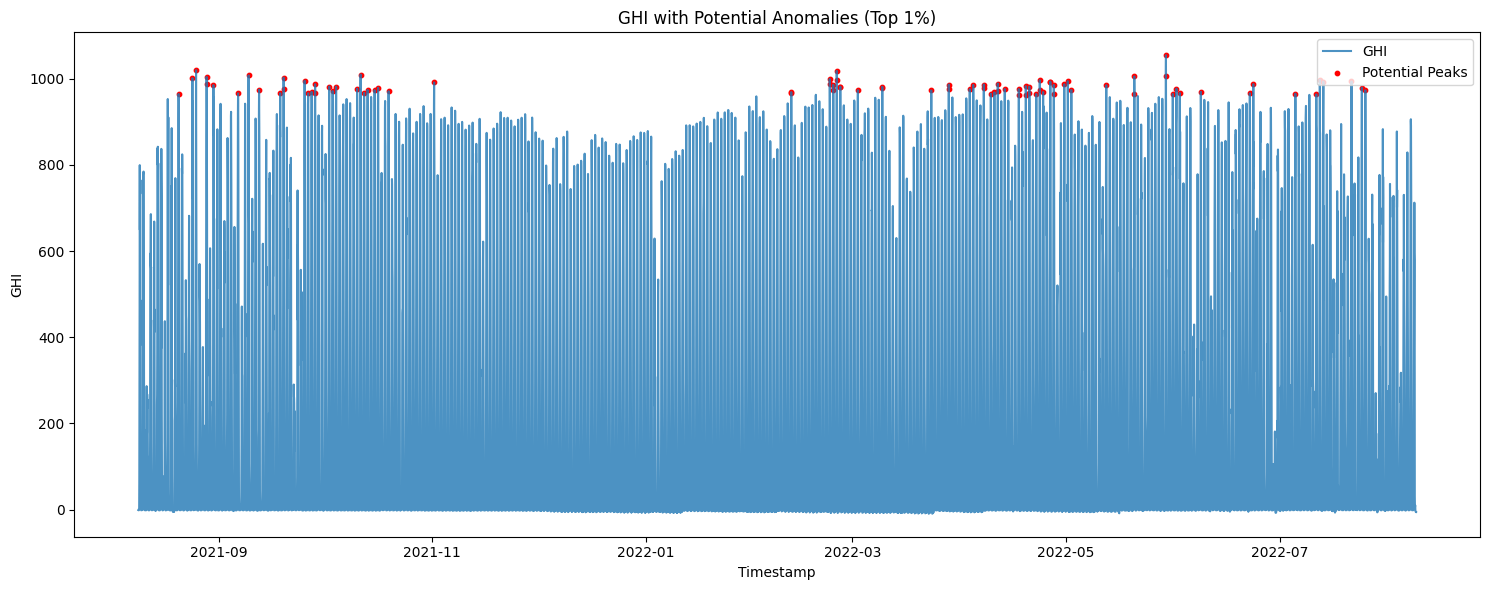

In [24]:
# Group by month and compute mean
monthly_mean = df_numeric.resample('m').mean()

plt.figure(figsize=(12,6))
for col in ['GHI', 'DNI', 'DHI', 'Tamb']:
    plt.plot(monthly_mean.index.month, monthly_mean[col], label=col)

plt.title("Monthly Average Trends of Solar and Temperature Data")
plt.xlabel("Month")
plt.ylabel("Mean Value")
plt.legend()
plt.grid(True)
plt.show()

df['hour'] = df.index.hour
hourly_pattern = df.groupby('hour')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()

plt.figure(figsize=(12,6))
for col in ['GHI', 'DNI', 'DHI', 'Tamb']:
    plt.plot(hourly_pattern.index, hourly_pattern[col], label=col)

plt.title("Average Diurnal Pattern (Hourly Averages Across All Days)")
plt.xlabel("Hour of Day")
plt.ylabel("Mean Value")
plt.legend()
plt.grid(True)
plt.show()

# detecting anomalies or peaks
plt.figure(figsize=(15,6))
plt.plot(df_hourly.index, df_hourly['GHI'], label='GHI', alpha=0.8)
plt.scatter(df_hourly.index[df_hourly['GHI'] > df_hourly['GHI'].quantile(0.99)], 
            df_hourly['GHI'][df_hourly['GHI'] > df_hourly['GHI'].quantile(0.99)],
            color='red', label='Potential Peaks', s=10)
plt.title("GHI with Potential Anomalies (Top 1%)")
plt.xlabel("Timestamp")
plt.ylabel("GHI")
plt.legend()
plt.tight_layout()
plt.show()


### Code to Group by Cleaning Flag

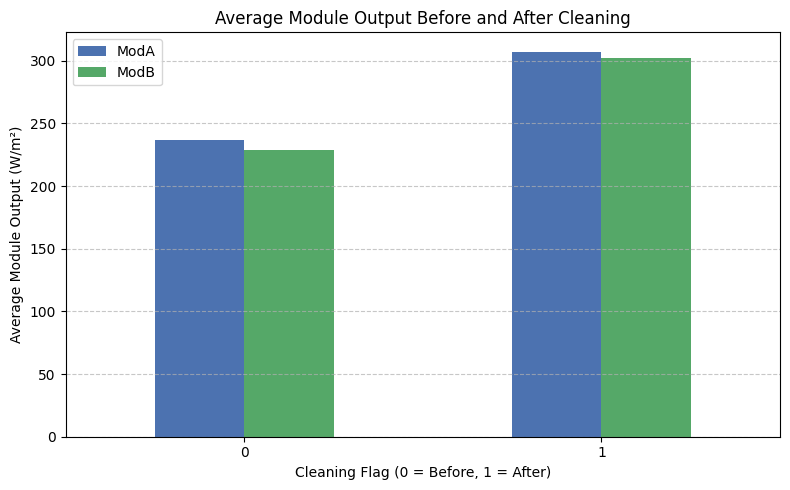

Average ModA/ModB output before vs after cleaning:

                ModA        ModB
Cleaning                        
0         236.459225  228.669520
1         307.229278  301.972165

Change after cleaning (%):
ModA    29.929073
ModB    32.056150
dtype: float64


In [25]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Cleaning is numeric
df['Cleaning'] = df['Cleaning'].astype(int)

# Group by Cleaning flag
mod_means = df.groupby('Cleaning')[['ModA', 'ModB']].mean()

# Plot comparison
mod_means.plot(kind='bar', figsize=(8,5), rot=0, color=['#4c72b0', '#55a868'])
plt.title("Average Module Output Before and After Cleaning")
plt.xlabel("Cleaning Flag (0 = Before, 1 = After)")
plt.ylabel("Average Module Output (W/m²)")
plt.legend(["ModA", "ModB"])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Optional: print numerical difference
print("Average ModA/ModB output before vs after cleaning:\n")
print(mod_means)
print("\nChange after cleaning (%):")
print((mod_means.loc[1] - mod_means.loc[0]) / mod_means.loc[0] * 100)


### Correlation & Relationship Analysis

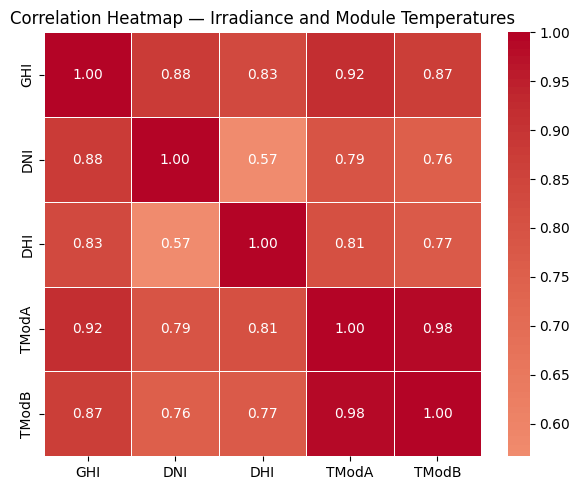

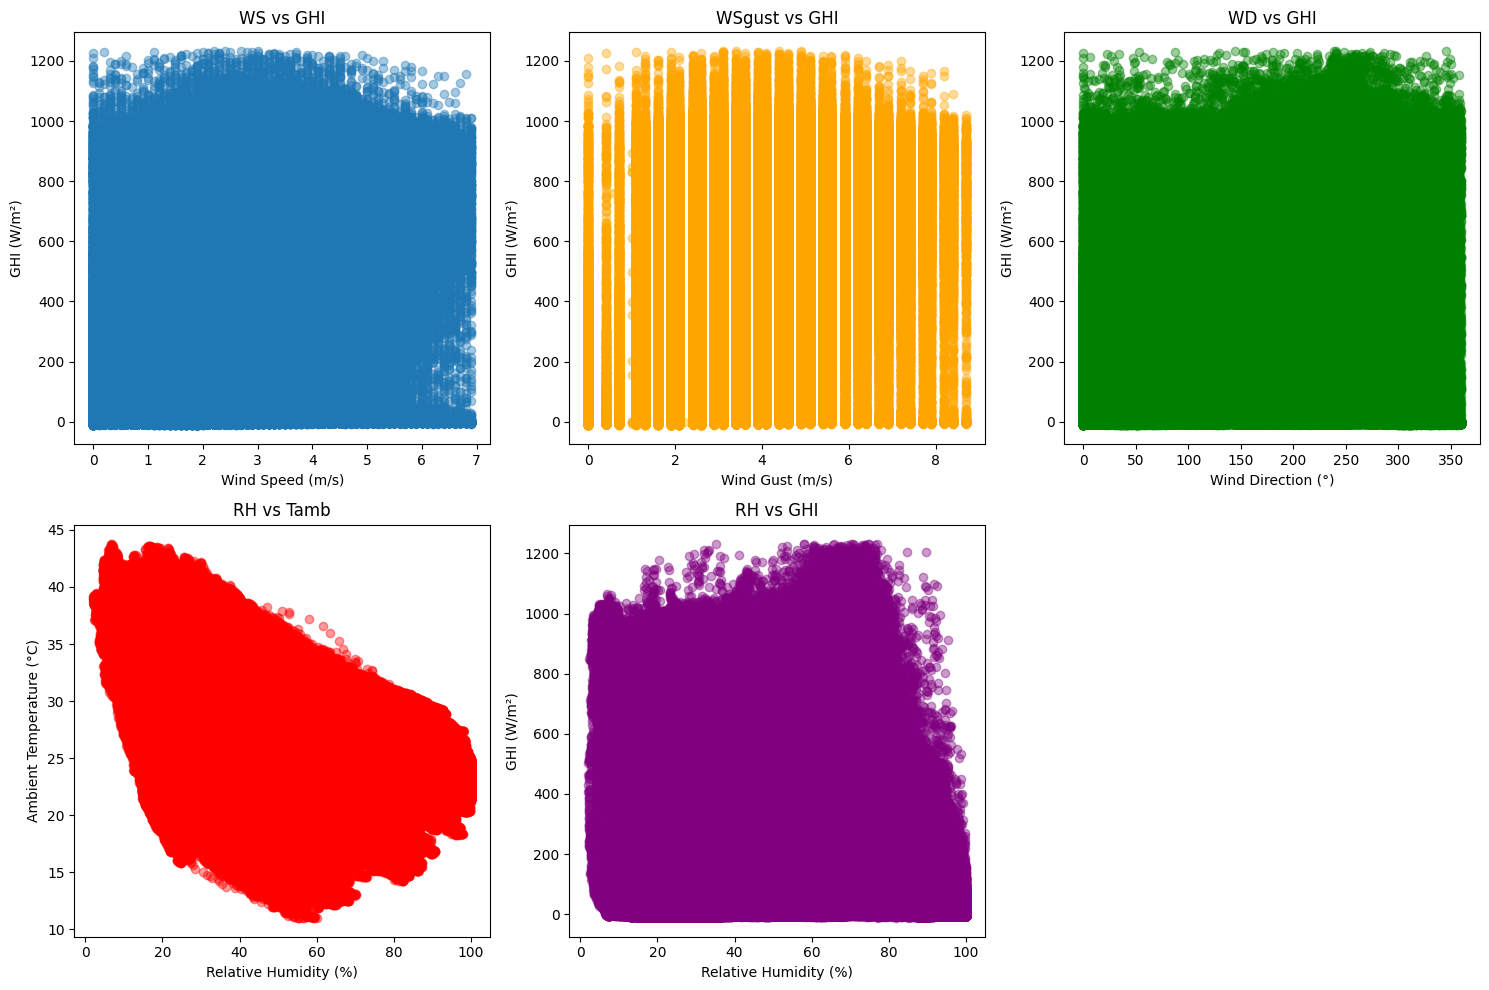

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant columns
corr_cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']

# Compute correlation matrix
corr_matrix = df[corr_cols].corr()

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap — Irradiance and Module Temperatures")
plt.tight_layout()
plt.show()

# Define scatter plots
plt.figure(figsize=(15, 10))

# (a) WS vs GHI
plt.subplot(2, 3, 1)
plt.scatter(df['WS'], df['GHI'], alpha=0.4)
plt.title("WS vs GHI")
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("GHI (W/m²)")

# (b) WSgust vs GHI
plt.subplot(2, 3, 2)
plt.scatter(df['WSgust'], df['GHI'], alpha=0.4, color='orange')
plt.title("WSgust vs GHI")
plt.xlabel("Wind Gust (m/s)")
plt.ylabel("GHI (W/m²)")

# (c) WD vs GHI
plt.subplot(2, 3, 3)
plt.scatter(df['WD'], df['GHI'], alpha=0.4, color='green')
plt.title("WD vs GHI")
plt.xlabel("Wind Direction (°)")
plt.ylabel("GHI (W/m²)")

# (d) RH vs Tamb
plt.subplot(2, 3, 4)
plt.scatter(df['RH'], df['Tamb'], alpha=0.4, color='red')
plt.title("RH vs Tamb")
plt.xlabel("Relative Humidity (%)")
plt.ylabel("Ambient Temperature (°C)")

# (e) RH vs GHI
plt.subplot(2, 3, 5)
plt.scatter(df['RH'], df['GHI'], alpha=0.4, color='purple')
plt.title("RH vs GHI")
plt.xlabel("Relative Humidity (%)")
plt.ylabel("GHI (W/m²)")

plt.tight_layout()
plt.show()


### visualizing wind behavior and value distributions

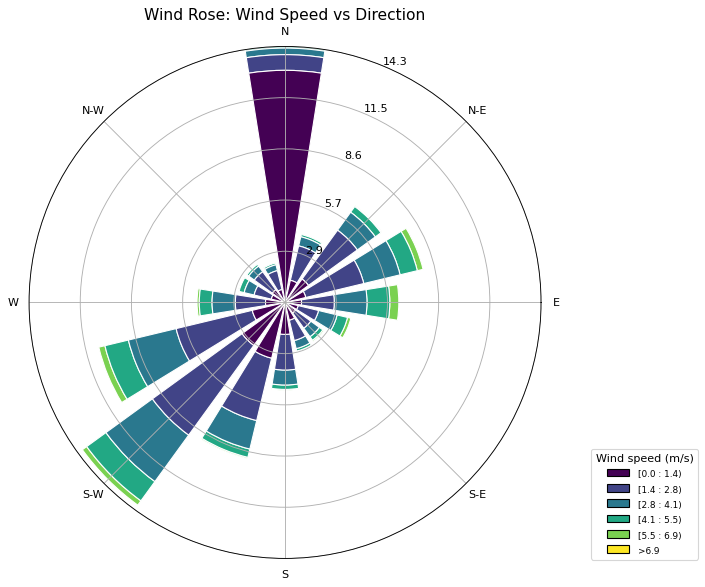

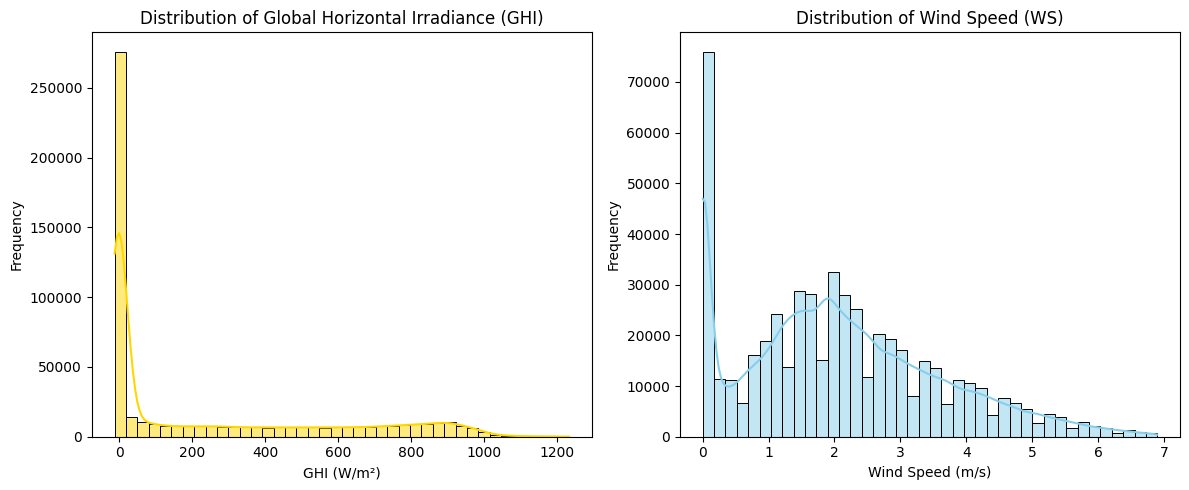

In [27]:
import matplotlib.pyplot as plt
from windrose import WindroseAxes

# Remove invalid data
df_valid = df.dropna(subset=['WS', 'WD'])

# Create wind rose
ax = WindroseAxes.from_ax()
ax.bar(df_valid['WD'], df_valid['WS'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend(title="Wind speed (m/s)", bbox_to_anchor=(1.1, 0))
plt.title("Wind Rose: Wind Speed vs Direction", fontsize=14)
plt.show()


plt.figure(figsize=(12, 5))

# GHI Histogram
plt.subplot(1, 2, 1)
sns.histplot(df['GHI'].dropna(), bins=40, kde=True, color='gold')
plt.title("Distribution of Global Horizontal Irradiance (GHI)")
plt.xlabel("GHI (W/m²)")
plt.ylabel("Frequency")

# WS Histogram
plt.subplot(1, 2, 2)
sns.histplot(df['WS'].dropna(), bins=40, kde=True, color='skyblue')
plt.title("Distribution of Wind Speed (WS)")
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


### Scatter Plots — RH vs Tamb, RH vs GHI

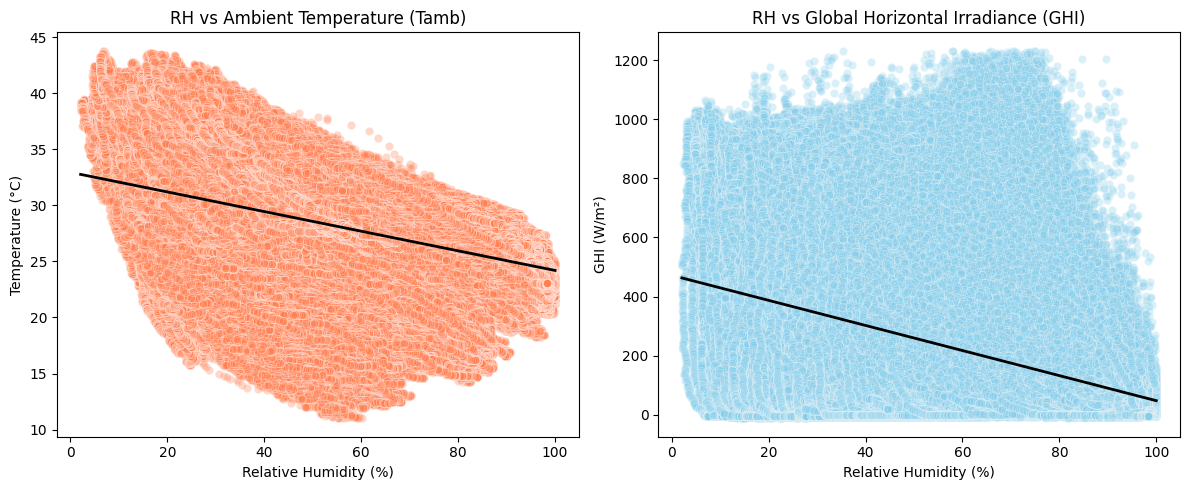

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

# RH vs Temperature
plt.subplot(1, 2, 1)
sns.scatterplot(x='RH', y='Tamb', data=df, alpha=0.3, color='coral')
sns.regplot(x='RH', y='Tamb', data=df, scatter=False, color='black', line_kws={'lw': 2})
plt.title("RH vs Ambient Temperature (Tamb)")
plt.xlabel("Relative Humidity (%)")
plt.ylabel("Temperature (°C)")

# RH vs GHI
plt.subplot(1, 2, 2)
sns.scatterplot(x='RH', y='GHI', data=df, alpha=0.3, color='skyblue')
sns.regplot(x='RH', y='GHI', data=df, scatter=False, color='black', line_kws={'lw': 2})
plt.title("RH vs Global Horizontal Irradiance (GHI)")
plt.xlabel("Relative Humidity (%)")
plt.ylabel("GHI (W/m²)")

plt.tight_layout()
plt.show()


### GHI vs. Tamb with bubble size = RH or BP.

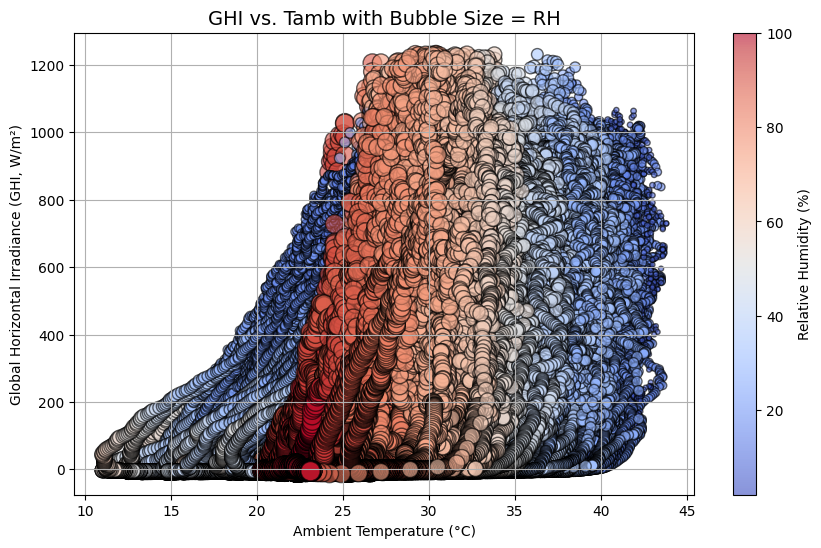

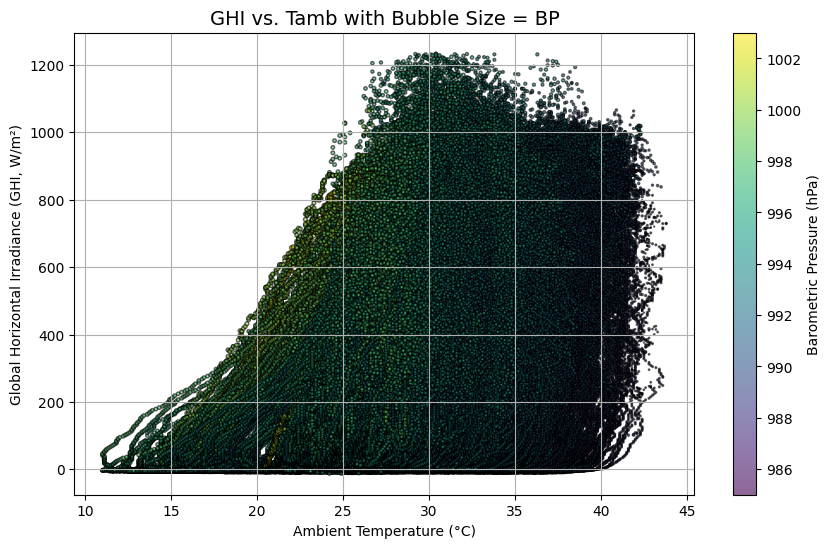

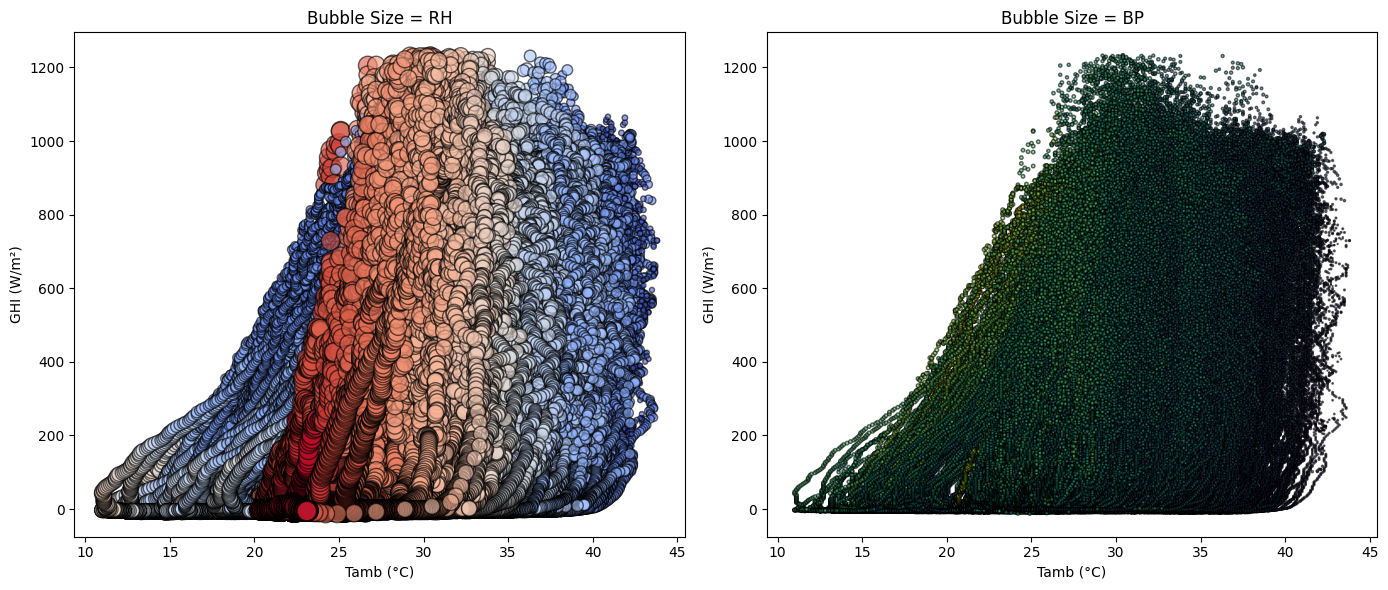

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

# Scatter with bubble size = RH
plt.scatter(
    df['Tamb'], df['GHI'],
    s=df['RH'] * 2,          # scale bubble size
    c=df['RH'],              # color by RH
    cmap='coolwarm', alpha=0.6, edgecolors='k'
)

plt.title('GHI vs. Tamb with Bubble Size = RH', fontsize=14)
plt.xlabel('Ambient Temperature (°C)')
plt.ylabel('Global Horizontal Irradiance (GHI, W/m²)')
plt.colorbar(label='Relative Humidity (%)')
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))

plt.scatter(
    df['Tamb'], df['GHI'],
    s=(df['BP'] - df['BP'].min()) / 2,  # normalize pressure to control bubble size
    c=df['BP'], cmap='viridis', alpha=0.6, edgecolors='k'
)

plt.title('GHI vs. Tamb with Bubble Size = BP', fontsize=14)
plt.xlabel('Ambient Temperature (°C)')
plt.ylabel('Global Horizontal Irradiance (GHI, W/m²)')
plt.colorbar(label='Barometric Pressure (hPa)')
plt.grid(True)
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14,6))

# RH
axes[0].scatter(df['Tamb'], df['GHI'], s=df['RH']*2, c=df['RH'], cmap='coolwarm', alpha=0.6, edgecolors='k')
axes[0].set_title('Bubble Size = RH')
axes[0].set_xlabel('Tamb (°C)')
axes[0].set_ylabel('GHI (W/m²)')

# BP
axes[1].scatter(df['Tamb'], df['GHI'], s=(df['BP'] - df['BP'].min())/2, c=df['BP'], cmap='viridis', alpha=0.6, edgecolors='k')
axes[1].set_title('Bubble Size = BP')
axes[1].set_xlabel('Tamb (°C)')
axes[1].set_ylabel('GHI (W/m²)')

plt.tight_layout()
plt.show()
